# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-kmeans'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [10]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [11]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [12]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [13]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [14]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [16]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [18]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)

        time_start = time.time()
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
        time_end = time.time()
        print(f"Model loaded in {time_end - time_start} s")
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8278, F1 Micro: 0.0483, F1 Macro: 0.017
Epoch 2/10, Train Loss: 0.4112, Accuracy: 0.8287, F1 Micro: 0.0251, F1 Macro: 0.0109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3817, Accuracy: 0.8313, F1 Micro: 0.0562, F1 Macro: 0.023
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3552, Accuracy: 0.8534, F1 Micro: 0.3322, F1 Macro: 0.1087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3425, Accuracy: 0.8667, F1 Micro: 0.4499, F1 Macro: 0.1904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3131, Accuracy: 0.8731, F1 Micro: 0.6036, F1 Macro: 0.2896
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2691, Accuracy: 0.8766, F1 Micro: 0.6219, F1 Macro: 0.3077
Epoch 8/10, Train Loss: 0.2634, Accuracy: 0.8822, F1 Micro: 0.5944, F1 Macro: 0.2945
Epoch 9/10, Train Loss: 0.2253, Accuracy: 0.8804, F1 Micro: 0.5629, F1 Macro: 0.2872
Epoch 10/10, Train Loss: 0.1952, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4716, Accuracy: 0.827, F1 Micro: 0.0032, F1 Macro: 0.0014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3721, Accuracy: 0.8573, F1 Micro: 0.3914, F1 Macro: 0.1202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3288, Accuracy: 0.8784, F1 Micro: 0.528, F1 Macro: 0.2464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2842, Accuracy: 0.8888, F1 Micro: 0.6299, F1 Macro: 0.3108
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.233, Accuracy: 0.8959, F1 Micro: 0.6684, F1 Macro: 0.3751
Epoch 6/10, Train Loss: 0.199, Accuracy: 0.8938, F1 Micro: 0.6263, F1 Macro: 0.3607
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1677, Accuracy: 0.9008, F1 Micro: 0.6861, F1 Macro: 0.4966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1401, Accuracy: 0.8996, F1 Micro: 0.7099, F1 Macro: 0.4862
Epoch 9/10, Train Loss: 0.1188, Accuracy: 0.8996, F1 Micro: 0.7001, F1 Macro: 0.5124
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4398, Accuracy: 0.8335, F1 Micro: 0.0858, F1 Macro: 0.0325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3509, Accuracy: 0.8809, F1 Micro: 0.5602, F1 Macro: 0.2601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.8968, F1 Micro: 0.6654, F1 Macro: 0.3607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2363, Accuracy: 0.9012, F1 Micro: 0.6935, F1 Macro: 0.4764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1926, Accuracy: 0.9037, F1 Micro: 0.7287, F1 Macro: 0.5372
Epoch 6/10, Train Loss: 0.1595, Accuracy: 0.9008, F1 Micro: 0.7251, F1 Macro: 0.5135
Epoch 7/10, Train Loss: 0.1402, Accuracy: 0.9072, F1 Micro: 0.6981, F1 Macro: 0.4837
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1085, Accuracy: 0.9124, F1 Micro: 0.7298, F1 Macro: 0.5439
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9065, F1 Micro: 0.7124, F1 Macro: 0.5471
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4231, Accuracy: 0.8443, F1 Micro: 0.2051, F1 Macro: 0.0753
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3298, Accuracy: 0.8876, F1 Micro: 0.6571, F1 Macro: 0.3428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2609, Accuracy: 0.9014, F1 Micro: 0.6879, F1 Macro: 0.4836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2092, Accuracy: 0.9094, F1 Micro: 0.7278, F1 Macro: 0.5407
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9106, F1 Micro: 0.7491, F1 Macro: 0.5636
Epoch 6/10, Train Loss: 0.14, Accuracy: 0.9096, F1 Micro: 0.7491, F1 Macro: 0.5748
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.9161, F1 Micro: 0.7382, F1 Macro: 0.5782
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9179, F1 Micro: 0.7458, F1 Macro: 0.5885
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.9128, F1 Micro: 0.7462, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0671, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4161, Accuracy: 0.8698, F1 Micro: 0.4992, F1 Macro: 0.2063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3077, Accuracy: 0.887, F1 Micro: 0.5697, F1 Macro: 0.2955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2528, Accuracy: 0.9095, F1 Micro: 0.725, F1 Macro: 0.5317
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2067, Accuracy: 0.9151, F1 Micro: 0.7308, F1 Macro: 0.5385
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9154, F1 Micro: 0.753, F1 Macro: 0.5581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.92, F1 Micro: 0.7552, F1 Macro: 0.5965
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.9165, F1 Micro: 0.7375, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9202, F1 Micro: 0.7563, F1 Macro: 0.6292
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9142, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4091, Accuracy: 0.8791, F1 Micro: 0.5988, F1 Macro: 0.2812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2908, Accuracy: 0.8972, F1 Micro: 0.6396, F1 Macro: 0.395
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.243, Accuracy: 0.9099, F1 Micro: 0.7305, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1925, Accuracy: 0.916, F1 Micro: 0.7405, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9203, F1 Micro: 0.7605, F1 Macro: 0.5919
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9195, F1 Micro: 0.7653, F1 Macro: 0.6144
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.918, F1 Micro: 0.7554, F1 Macro: 0.5902
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9164, F1 Micro: 0.764, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9184, F1 Micro: 0.7666, F1 Macro: 0.6434
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.394, Accuracy: 0.8822, F1 Micro: 0.5934, F1 Macro: 0.2784
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2828, Accuracy: 0.9011, F1 Micro: 0.6581, F1 Macro: 0.4855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.227, Accuracy: 0.9093, F1 Micro: 0.7397, F1 Macro: 0.5746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1837, Accuracy: 0.9195, F1 Micro: 0.7571, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9219, F1 Micro: 0.7632, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9216, F1 Micro: 0.7649, F1 Macro: 0.6308
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.918, F1 Micro: 0.7684, F1 Macro: 0.6534
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9201, F1 Micro: 0.7659, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9189, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8811, F1 Micro: 0.5501, F1 Macro: 0.2565
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2725, Accuracy: 0.9087, F1 Micro: 0.7182, F1 Macro: 0.5094
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9135, F1 Micro: 0.7497, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9209, F1 Micro: 0.7632, F1 Macro: 0.5942
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9203, F1 Micro: 0.7677, F1 Macro: 0.6258
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.923, F1 Micro: 0.7654, F1 Macro: 0.628
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9204, F1 Micro: 0.7674, F1 Macro: 0.6396
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9207, F1 Micro: 0.7748, F1 Macro: 0.6613
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9216, F1 Micro: 0.7724, F1 Macro: 0.6676
Epoch 10/10, Train Loss: 0.0546, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3839, Accuracy: 0.8875, F1 Micro: 0.6486, F1 Macro: 0.3296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.9106, F1 Micro: 0.722, F1 Macro: 0.5347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.918, F1 Micro: 0.7486, F1 Macro: 0.5638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9218, F1 Micro: 0.7623, F1 Macro: 0.5986
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9212, F1 Micro: 0.7623, F1 Macro: 0.6223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.9235, F1 Micro: 0.7761, F1 Macro: 0.6661
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9226, F1 Micro: 0.7739, F1 Macro: 0.6439
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9239, F1 Micro: 0.7718, F1 Macro: 0.6607
Epoch 9/10, Train Loss: 0.0653, Accuracy: 0.9223, F1 Micro: 0.7755, F1 Macro: 0.6696
Epoch 10/10, Train Loss: 0.0552, Accuracy: 0.924, F1 Micro: 0.774, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3779, Accuracy: 0.8912, F1 Micro: 0.6523, F1 Macro: 0.3535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9117, F1 Micro: 0.7258, F1 Macro: 0.5456
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.9181, F1 Micro: 0.7421, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9195, F1 Micro: 0.766, F1 Macro: 0.6143
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9195, F1 Micro: 0.7639, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9248, F1 Micro: 0.781, F1 Macro: 0.6654
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9224, F1 Micro: 0.7706, F1 Macro: 0.6643
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9256, F1 Micro: 0.7759, F1 Macro: 0.6635
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.9219, F1 Micro: 0.7784, F1 Macro: 0.6904
Epoch 10/10, Train Loss: 0.0536, Accuracy: 0.9226, F1 Micro: 0.7752, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8936, F1 Micro: 0.6356, F1 Macro: 0.35
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.9129, F1 Micro: 0.7278, F1 Macro: 0.5569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.9194, F1 Micro: 0.7445, F1 Macro: 0.5656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9237, F1 Micro: 0.7703, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9217, F1 Micro: 0.7743, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9251, F1 Micro: 0.7781, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.9253, F1 Micro: 0.7868, F1 Macro: 0.7026
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9232, F1 Micro: 0.7758, F1 Macro: 0.7017
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9249, F1 Micro: 0.7817, F1 Macro: 0.7042
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3664, Accuracy: 0.8966, F1 Micro: 0.663, F1 Macro: 0.3713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9124, F1 Micro: 0.7286, F1 Macro: 0.5617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9184, F1 Micro: 0.7618, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9232, F1 Micro: 0.7715, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9238, F1 Micro: 0.7764, F1 Macro: 0.6584
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9226, F1 Micro: 0.7737, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9269, F1 Micro: 0.7772, F1 Macro: 0.6764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9243, F1 Micro: 0.7783, F1 Macro: 0.7023
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.923, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.8932, F1 Micro: 0.6183, F1 Macro: 0.3281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2508, Accuracy: 0.9137, F1 Micro: 0.7301, F1 Macro: 0.5612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9219, F1 Micro: 0.754, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9243, F1 Micro: 0.7617, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9255, F1 Micro: 0.7691, F1 Macro: 0.6459
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9251, F1 Micro: 0.778, F1 Macro: 0.6844
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9226, F1 Micro: 0.7748, F1 Macro: 0.655
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9255, F1 Micro: 0.7703, F1 Macro: 0.6775
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9246, F1 Micro: 0.7748, F1 Macro: 0.6987
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3656, Accuracy: 0.8962, F1 Micro: 0.6609, F1 Macro: 0.3765
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.9153, F1 Micro: 0.7472, F1 Macro: 0.5728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9219, F1 Micro: 0.7738, F1 Macro: 0.6275
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9261, F1 Micro: 0.7784, F1 Macro: 0.624
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9211, F1 Micro: 0.7756, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9255, F1 Micro: 0.7862, F1 Macro: 0.6768
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9262, F1 Micro: 0.7818, F1 Macro: 0.6684
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9267, F1 Micro: 0.7841, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9241, F1 Micro: 0.7863, F1 Macro: 0.7276
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3634, Accuracy: 0.899, F1 Micro: 0.6978, F1 Macro: 0.4932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.9109, F1 Micro: 0.7463, F1 Macro: 0.5669
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.9201, F1 Micro: 0.7656, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9258, F1 Micro: 0.7747, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9216, F1 Micro: 0.776, F1 Macro: 0.6598
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9185, F1 Micro: 0.7742, F1 Macro: 0.6859
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9244, F1 Micro: 0.7732, F1 Macro: 0.6667
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.928, F1 Micro: 0.7858, F1 Macro: 0.713
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9267, F1 Micro: 0.7877, F1 Macro: 0.7274
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.358, Accuracy: 0.9001, F1 Micro: 0.7068, F1 Macro: 0.51
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2433, Accuracy: 0.9159, F1 Micro: 0.7473, F1 Macro: 0.5665
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9225, F1 Micro: 0.7588, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9272, F1 Micro: 0.7854, F1 Macro: 0.6719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9254, F1 Micro: 0.7859, F1 Macro: 0.6759
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9275, F1 Micro: 0.7837, F1 Macro: 0.6503
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9279, F1 Micro: 0.7887, F1 Macro: 0.704
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9262, F1 Micro: 0.7885, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.928, F1 Micro: 0.791, F1 Macro: 0.7306
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.9022, F1 Micro: 0.6862, F1 Macro: 0.44
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2391, Accuracy: 0.9169, F1 Micro: 0.7501, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9218, F1 Micro: 0.7707, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9263, F1 Micro: 0.7833, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9229, F1 Micro: 0.7837, F1 Macro: 0.6732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9294, F1 Micro: 0.7907, F1 Macro: 0.7068
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9213, F1 Micro: 0.7754, F1 Macro: 0.6951
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9279, F1 Micro: 0.7895, F1 Macro: 0.7257
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9266, F1 Micro: 0.7843, F1 Macro: 0.7172
Epoch 10/10, Train Loss: 0.0456, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3543, Accuracy: 0.9026, F1 Micro: 0.682, F1 Macro: 0.4321
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.9167, F1 Micro: 0.751, F1 Macro: 0.5783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9239, F1 Micro: 0.7753, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.9234, F1 Micro: 0.779, F1 Macro: 0.6441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9275, F1 Micro: 0.7823, F1 Macro: 0.6753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9259, F1 Micro: 0.7876, F1 Macro: 0.6955
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9274, F1 Micro: 0.7823, F1 Macro: 0.7086
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9286, F1 Micro: 0.7914, F1 Macro: 0.7193
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9218, F1 Micro: 0.7854, F1 Macro: 0.7251
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.352, Accuracy: 0.9026, F1 Micro: 0.6926, F1 Macro: 0.4667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2378, Accuracy: 0.9187, F1 Micro: 0.7495, F1 Macro: 0.5542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1888, Accuracy: 0.9221, F1 Micro: 0.7706, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9258, F1 Micro: 0.7799, F1 Macro: 0.6792
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9254, F1 Micro: 0.7788, F1 Macro: 0.6755
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9302, F1 Micro: 0.7903, F1 Macro: 0.6809
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9229, F1 Micro: 0.7833, F1 Macro: 0.7099
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9272, F1 Micro: 0.7877, F1 Macro: 0.717
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9257, F1 Micro: 0.7885, F1 Macro: 0.7313
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.9273, F1 Micro: 0.7875, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3512, Accuracy: 0.9037, F1 Micro: 0.695, F1 Macro: 0.4478
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.9194, F1 Micro: 0.7473, F1 Macro: 0.5768
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9231, F1 Micro: 0.7753, F1 Macro: 0.6418
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9271, F1 Micro: 0.7819, F1 Macro: 0.6787
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9281, F1 Micro: 0.7873, F1 Macro: 0.6865
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9294, F1 Micro: 0.7909, F1 Macro: 0.6945
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9301, F1 Micro: 0.7902, F1 Macro: 0.7194
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.927, F1 Micro: 0.7864, F1 Macro: 0.7182
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9267, F1 Micro: 0.7833, F1 Macro: 0.7113
Epoch 10/10, Train Loss: 0.0468, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3458, Accuracy: 0.9029, F1 Micro: 0.698, F1 Macro: 0.4626
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.9173, F1 Micro: 0.7535, F1 Macro: 0.5753
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9224, F1 Micro: 0.7676, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9256, F1 Micro: 0.7801, F1 Macro: 0.6574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9265, F1 Micro: 0.7871, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.927, F1 Micro: 0.7887, F1 Macro: 0.7056
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9272, F1 Micro: 0.7899, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9295, F1 Micro: 0.7948, F1 Macro: 0.724
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9271, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3474, Accuracy: 0.9013, F1 Micro: 0.6674, F1 Macro: 0.483
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.9192, F1 Micro: 0.7576, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.9239, F1 Micro: 0.764, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.9233, F1 Micro: 0.7798, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.928, F1 Micro: 0.7848, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9271, F1 Micro: 0.7899, F1 Macro: 0.7165
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9283, F1 Micro: 0.7856, F1 Macro: 0.7073
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9248, F1 Micro: 0.7819, F1 Macro: 0.7086
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9253, F1 Micro: 0.7851, F1 Macro: 0.7221
Epoch 10/10, Train Loss: 0.0471, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3479, Accuracy: 0.9044, F1 Micro: 0.6923, F1 Macro: 0.4743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.9165, F1 Micro: 0.7423, F1 Macro: 0.5441
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9242, F1 Micro: 0.7626, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9264, F1 Micro: 0.7734, F1 Macro: 0.6554
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9256, F1 Micro: 0.771, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9286, F1 Micro: 0.7928, F1 Macro: 0.7179
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9268, F1 Micro: 0.7796, F1 Macro: 0.6942
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9261, F1 Micro: 0.7852, F1 Macro: 0.7219
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9232, F1 Micro: 0.7811, F1 Macro: 0.712
Epoch 10/10, Train Loss: 0.0462, Accuracy: 0.9278, F1 Micro: 0.7913, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3427, Accuracy: 0.9032, F1 Micro: 0.6985, F1 Macro: 0.501
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.9187, F1 Micro: 0.753, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.9249, F1 Micro: 0.7697, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1448, Accuracy: 0.9286, F1 Micro: 0.7817, F1 Macro: 0.6556
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9255, F1 Micro: 0.7656, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9284, F1 Micro: 0.792, F1 Macro: 0.7178
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9286, F1 Micro: 0.7889, F1 Macro: 0.7059
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9258, F1 Micro: 0.7871, F1 Macro: 0.7203
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.924, F1 Micro: 0.7827, F1 Macro: 0.7245
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.926, F1 Micro: 0.7805, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3393, Accuracy: 0.9036, F1 Micro: 0.6827, F1 Macro: 0.4415
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2272, Accuracy: 0.9196, F1 Micro: 0.7549, F1 Macro: 0.5724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9266, F1 Micro: 0.7719, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9292, F1 Micro: 0.7903, F1 Macro: 0.6876
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.929, F1 Micro: 0.7934, F1 Macro: 0.6919
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9295, F1 Micro: 0.7933, F1 Macro: 0.7232
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9283, F1 Micro: 0.7926, F1 Macro: 0.7215
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9277, F1 Micro: 0.7905, F1 Macro: 0.7243
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9269, F1 Micro: 0.7819, F1 Macro: 0.7193
Epoch 10/10, Train Loss: 0.0442, Accuracy: 0.927, F1 Micro: 0.7859, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3364, Accuracy: 0.9073, F1 Micro: 0.7115, F1 Macro: 0.5032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2214, Accuracy: 0.9186, F1 Micro: 0.7428, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9247, F1 Micro: 0.782, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9289, F1 Micro: 0.7871, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9297, F1 Micro: 0.7949, F1 Macro: 0.7099
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9266, F1 Micro: 0.7892, F1 Macro: 0.7071
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.928, F1 Micro: 0.7872, F1 Macro: 0.7148
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9254, F1 Micro: 0.7889, F1 Macro: 0.7253
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9287, F1 Micro: 0.7898, F1 Macro: 0.7216
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.9248, F1 Micro: 0.7843, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3298, Accuracy: 0.9057, F1 Micro: 0.7251, F1 Macro: 0.5149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2174, Accuracy: 0.9206, F1 Micro: 0.7672, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9253, F1 Micro: 0.7755, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.9304, F1 Micro: 0.7894, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9267, F1 Micro: 0.7903, F1 Macro: 0.7027
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9273, F1 Micro: 0.7876, F1 Macro: 0.7077
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9249, F1 Micro: 0.7863, F1 Macro: 0.7227
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9231, F1 Micro: 0.7799, F1 Macro: 0.7119
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9228, F1 Micro: 0.7842, F1 Macro: 0.7164
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.9293, F1 Micro: 0.7866, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3273, Accuracy: 0.905, F1 Micro: 0.6963, F1 Macro: 0.4742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.216, Accuracy: 0.9204, F1 Micro: 0.7501, F1 Macro: 0.5889
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9259, F1 Micro: 0.7737, F1 Macro: 0.6303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.928, F1 Micro: 0.7804, F1 Macro: 0.6741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1087, Accuracy: 0.9284, F1 Micro: 0.7805, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.9271, F1 Micro: 0.7933, F1 Macro: 0.7232
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9266, F1 Micro: 0.7775, F1 Macro: 0.7168
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9289, F1 Micro: 0.7862, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9277, F1 Micro: 0.7908, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 10

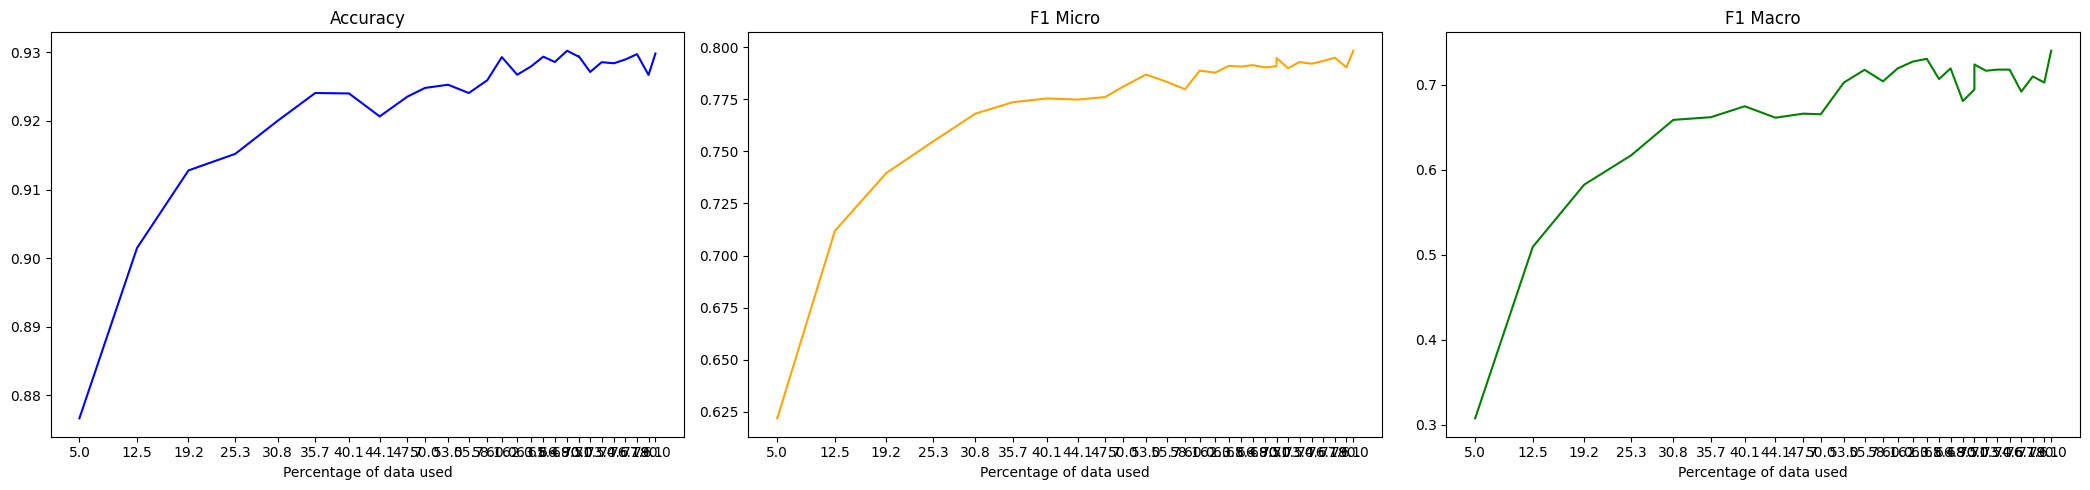

In [22]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.524, Accuracy: 0.8301, F1 Micro: 0.2873, F1 Macro: 0.0657
Epoch 2/10, Train Loss: 0.3962, Accuracy: 0.836, F1 Micro: 0.144, F1 Macro: 0.0516
Epoch 3/10, Train Loss: 0.3689, Accuracy: 0.8477, F1 Micro: 0.2738, F1 Macro: 0.0968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.342, Accuracy: 0.8656, F1 Micro: 0.4801, F1 Macro: 0.2063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3117, Accuracy: 0.8768, F1 Micro: 0.5736, F1 Macro: 0.2667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2746, Accuracy: 0.88, F1 Micro: 0.5854, F1 Macro: 0.2747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2515, Accuracy: 0.8841, F1 Micro: 0.5877, F1 Macro: 0.2855
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2305, Accuracy: 0.8869, F1 Micro: 0.6337, F1 Macro: 0.3399
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2015, Accuracy: 0.8891, F1 Micro: 0.6409, F1 Macro: 0.3499
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4553, Accuracy: 0.8283, F1 Micro: 0.0247, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3528, Accuracy: 0.8639, F1 Micro: 0.4504, F1 Macro: 0.1963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.306, Accuracy: 0.8817, F1 Micro: 0.6307, F1 Macro: 0.296
Epoch 4/10, Train Loss: 0.2581, Accuracy: 0.8909, F1 Micro: 0.6283, F1 Macro: 0.335
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2098, Accuracy: 0.896, F1 Micro: 0.6449, F1 Macro: 0.3688
Epoch 6/10, Train Loss: 0.1899, Accuracy: 0.8962, F1 Micro: 0.6343, F1 Macro: 0.4019
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1645, Accuracy: 0.9027, F1 Micro: 0.6832, F1 Macro: 0.4727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1331, Accuracy: 0.904, F1 Micro: 0.6948, F1 Macro: 0.5102
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1069, Accuracy: 0.9027, F1 Micro: 0.7098, F1 Macro: 0.4755
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4268, Accuracy: 0.8287, F1 Micro: 0.0237, F1 Macro: 0.0104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3379, Accuracy: 0.8782, F1 Micro: 0.5308, F1 Macro: 0.2512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2709, Accuracy: 0.8944, F1 Micro: 0.6817, F1 Macro: 0.3719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2251, Accuracy: 0.9036, F1 Micro: 0.6917, F1 Macro: 0.4561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1902, Accuracy: 0.9062, F1 Micro: 0.7191, F1 Macro: 0.5162
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.908, F1 Micro: 0.7034, F1 Macro: 0.494
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.9112, F1 Micro: 0.7192, F1 Macro: 0.5383
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.9105, F1 Micro: 0.729, F1 Macro: 0.5508
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.9098, F1 Micro: 0.7103, F1 Macro: 0.5353
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4106, Accuracy: 0.8427, F1 Micro: 0.2022, F1 Macro: 0.0797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3152, Accuracy: 0.8892, F1 Micro: 0.609, F1 Macro: 0.3078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2469, Accuracy: 0.9019, F1 Micro: 0.675, F1 Macro: 0.4493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2124, Accuracy: 0.9088, F1 Micro: 0.718, F1 Macro: 0.5165
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9137, F1 Micro: 0.7309, F1 Macro: 0.5635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9151, F1 Micro: 0.7349, F1 Macro: 0.5447
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9154, F1 Micro: 0.7344, F1 Macro: 0.5553
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9149, F1 Micro: 0.728, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.9121, F1 Micro: 0.748, F1 Macro: 0.5821
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3987, Accuracy: 0.8717, F1 Micro: 0.512, F1 Macro: 0.2357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3015, Accuracy: 0.8993, F1 Micro: 0.6787, F1 Macro: 0.3742
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.244, Accuracy: 0.9085, F1 Micro: 0.7278, F1 Macro: 0.5251
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.9141, F1 Micro: 0.7514, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9191, F1 Micro: 0.7554, F1 Macro: 0.5766
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.917, F1 Micro: 0.7532, F1 Macro: 0.5693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.919, F1 Micro: 0.7605, F1 Macro: 0.6036
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9175, F1 Micro: 0.7557, F1 Macro: 0.6013
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9184, F1 Micro: 0.76, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3992, Accuracy: 0.8784, F1 Micro: 0.5943, F1 Macro: 0.2781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2849, Accuracy: 0.9018, F1 Micro: 0.6921, F1 Macro: 0.4086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2291, Accuracy: 0.9116, F1 Micro: 0.7249, F1 Macro: 0.5158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1886, Accuracy: 0.9178, F1 Micro: 0.7518, F1 Macro: 0.5723
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9181, F1 Micro: 0.7514, F1 Macro: 0.577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9196, F1 Micro: 0.7534, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9206, F1 Micro: 0.7646, F1 Macro: 0.6107
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9209, F1 Micro: 0.7643, F1 Macro: 0.6202
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9184, F1 Micro: 0.7472, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.88, F1 Micro: 0.6315, F1 Macro: 0.2954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2815, Accuracy: 0.907, F1 Micro: 0.7155, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.228, Accuracy: 0.9116, F1 Micro: 0.7404, F1 Macro: 0.5494
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.9173, F1 Micro: 0.7371, F1 Macro: 0.5525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9194, F1 Micro: 0.7565, F1 Macro: 0.5984
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9209, F1 Micro: 0.7549, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9212, F1 Micro: 0.7711, F1 Macro: 0.6356
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9217, F1 Micro: 0.7692, F1 Macro: 0.6408
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.9209, F1 Micro: 0.767, F1 Macro: 0.6269
Epoch 10/10, Train Loss: 0.0576, Accuracy: 0.922, F1 Micro: 0.7683, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.382, Accuracy: 0.8876, F1 Micro: 0.6402, F1 Macro: 0.3211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2728, Accuracy: 0.9046, F1 Micro: 0.7231, F1 Macro: 0.5173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.911, F1 Micro: 0.7501, F1 Macro: 0.5573
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9179, F1 Micro: 0.7472, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9204, F1 Micro: 0.7648, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9183, F1 Micro: 0.7666, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9209, F1 Micro: 0.7668, F1 Macro: 0.6383
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9196, F1 Micro: 0.7615, F1 Macro: 0.6416
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9226, F1 Micro: 0.7624, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.371, Accuracy: 0.8898, F1 Micro: 0.6132, F1 Macro: 0.3066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.907, F1 Micro: 0.6829, F1 Macro: 0.4484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.916, F1 Micro: 0.7493, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.919, F1 Micro: 0.7548, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9201, F1 Micro: 0.7567, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.9238, F1 Micro: 0.7771, F1 Macro: 0.6315
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9206, F1 Micro: 0.7685, F1 Macro: 0.6256
Epoch 8/10, Train Loss: 0.0767, Accuracy: 0.9243, F1 Micro: 0.7686, F1 Macro: 0.6503
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9232, F1 Micro: 0.7717, F1 Macro: 0.6666
Epoch 10/10, Train Loss: 0.0515, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.8931, F1 Micro: 0.6537, F1 Macro: 0.3384
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.9105, F1 Micro: 0.7326, F1 Macro: 0.5522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9206, F1 Micro: 0.7522, F1 Macro: 0.5813
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9155, F1 Micro: 0.7328, F1 Macro: 0.5274
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9207, F1 Micro: 0.75, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.919, F1 Micro: 0.7685, F1 Macro: 0.6204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0915, Accuracy: 0.9246, F1 Micro: 0.7743, F1 Macro: 0.6603
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9253, F1 Micro: 0.773, F1 Macro: 0.6483
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.918, F1 Micro: 0.7689, F1 Macro: 0.6497
Epoch 10/10, Train Loss: 0.0531, Accuracy: 0.924, F1 Micro: 0.7737, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.8925, F1 Micro: 0.618, F1 Macro: 0.3396
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2569, Accuracy: 0.9118, F1 Micro: 0.7212, F1 Macro: 0.5302
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9196, F1 Micro: 0.7545, F1 Macro: 0.5856
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9206, F1 Micro: 0.7691, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9243, F1 Micro: 0.7759, F1 Macro: 0.6367
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9251, F1 Micro: 0.7684, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9238, F1 Micro: 0.7812, F1 Macro: 0.6687
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9232, F1 Micro: 0.7675, F1 Macro: 0.6344
Epoch 9/10, Train Loss: 0.066, Accuracy: 0.9182, F1 Micro: 0.7614, F1 Macro: 0.6655
Epoch 10/10, Train Loss: 0.052, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3645, Accuracy: 0.886, F1 Micro: 0.5662, F1 Macro: 0.2891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9143, F1 Micro: 0.7361, F1 Macro: 0.5557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9188, F1 Micro: 0.7578, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9234, F1 Micro: 0.7731, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9249, F1 Micro: 0.7761, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9267, F1 Micro: 0.7802, F1 Macro: 0.6505
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9233, F1 Micro: 0.7756, F1 Macro: 0.6732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9255, F1 Micro: 0.7817, F1 Macro: 0.6755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9262, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3549, Accuracy: 0.8977, F1 Micro: 0.6565, F1 Macro: 0.3546
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.916, F1 Micro: 0.7419, F1 Macro: 0.5499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9214, F1 Micro: 0.7615, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9231, F1 Micro: 0.7668, F1 Macro: 0.6089
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.92, F1 Micro: 0.7696, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9243, F1 Micro: 0.7742, F1 Macro: 0.6441
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9242, F1 Micro: 0.7711, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.925, F1 Micro: 0.7746, F1 Macro: 0.6621
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9239, F1 Micro: 0.7716, F1 Macro: 0.6874
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3577, Accuracy: 0.8999, F1 Micro: 0.6871, F1 Macro: 0.3893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9156, F1 Micro: 0.7364, F1 Macro: 0.5586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9227, F1 Micro: 0.7723, F1 Macro: 0.597
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9171, F1 Micro: 0.7677, F1 Macro: 0.6208
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9253, F1 Micro: 0.7671, F1 Macro: 0.6468
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9276, F1 Micro: 0.7798, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.928, F1 Micro: 0.782, F1 Macro: 0.6698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9267, F1 Micro: 0.7859, F1 Macro: 0.6996
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9275, F1 Micro: 0.7813, F1 Macro: 0.7043
Epoch 10/10, Train Loss: 0.0487, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3525, Accuracy: 0.8987, F1 Micro: 0.678, F1 Macro: 0.4212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.9139, F1 Micro: 0.7423, F1 Macro: 0.5431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9232, F1 Micro: 0.7685, F1 Macro: 0.605
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9236, F1 Micro: 0.7606, F1 Macro: 0.6283
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9247, F1 Micro: 0.7786, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9276, F1 Micro: 0.7837, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9254, F1 Micro: 0.7674, F1 Macro: 0.6538
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9268, F1 Micro: 0.7811, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9294, F1 Micro: 0.7913, F1 Macro: 0.7122
Epoch 10/10, Train Loss: 0.0469, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3489, Accuracy: 0.9008, F1 Micro: 0.6737, F1 Macro: 0.4207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.9167, F1 Micro: 0.7491, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.9212, F1 Micro: 0.7594, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9249, F1 Micro: 0.7752, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9259, F1 Micro: 0.7797, F1 Macro: 0.6634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9256, F1 Micro: 0.7805, F1 Macro: 0.6724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.928, F1 Micro: 0.7866, F1 Macro: 0.6933
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9273, F1 Micro: 0.776, F1 Macro: 0.681
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9281, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.8996, F1 Micro: 0.656, F1 Macro: 0.3813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.9171, F1 Micro: 0.7448, F1 Macro: 0.5483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1919, Accuracy: 0.9215, F1 Micro: 0.769, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9233, F1 Micro: 0.7719, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9238, F1 Micro: 0.7795, F1 Macro: 0.6643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9264, F1 Micro: 0.7818, F1 Macro: 0.689
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9246, F1 Micro: 0.7766, F1 Macro: 0.6828
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9227, F1 Micro: 0.7771, F1 Macro: 0.7034
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9273, F1 Micro: 0.7885, F1 Macro: 0.7021
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.9046, F1 Micro: 0.6885, F1 Macro: 0.4728
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2374, Accuracy: 0.9094, F1 Micro: 0.7481, F1 Macro: 0.5708
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9233, F1 Micro: 0.7742, F1 Macro: 0.6121
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9245, F1 Micro: 0.7732, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9246, F1 Micro: 0.7855, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9258, F1 Micro: 0.7869, F1 Macro: 0.6853
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9201, F1 Micro: 0.7764, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9261, F1 Micro: 0.7899, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9271, F1 Micro: 0.7903, F1 Macro: 0.7176
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3474, Accuracy: 0.9024, F1 Micro: 0.7096, F1 Macro: 0.493
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.9189, F1 Micro: 0.7442, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1931, Accuracy: 0.9239, F1 Micro: 0.7542, F1 Macro: 0.5914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9209, F1 Micro: 0.7716, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9271, F1 Micro: 0.7779, F1 Macro: 0.6599
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9248, F1 Micro: 0.7774, F1 Macro: 0.6931
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9283, F1 Micro: 0.7887, F1 Macro: 0.7069
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9236, F1 Micro: 0.7862, F1 Macro: 0.7012
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.924, F1 Micro: 0.7852, F1 Macro: 0.7148
Epoch 10/10, Train Loss: 0.0479, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3485, Accuracy: 0.9034, F1 Micro: 0.6869, F1 Macro: 0.4008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9178, F1 Micro: 0.7556, F1 Macro: 0.5808
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1858, Accuracy: 0.9228, F1 Micro: 0.7771, F1 Macro: 0.6122
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9293, F1 Micro: 0.7881, F1 Macro: 0.6585
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9249, F1 Micro: 0.7744, F1 Macro: 0.665
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9267, F1 Micro: 0.7826, F1 Macro: 0.6719
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9295, F1 Micro: 0.7859, F1 Macro: 0.6853
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9291, F1 Micro: 0.7886, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9285, F1 Micro: 0.7912, F1 Macro: 0.7182
Epoch 10/10, Train Loss: 0.0456, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.344, Accuracy: 0.8976, F1 Micro: 0.6417, F1 Macro: 0.3495
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2374, Accuracy: 0.9145, F1 Micro: 0.7419, F1 Macro: 0.5622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.9231, F1 Micro: 0.7763, F1 Macro: 0.6139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9261, F1 Micro: 0.785, F1 Macro: 0.6559
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9263, F1 Micro: 0.7841, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9263, F1 Micro: 0.786, F1 Macro: 0.6725
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9257, F1 Micro: 0.782, F1 Macro: 0.6921
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9234, F1 Micro: 0.7838, F1 Macro: 0.7039
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9302, F1 Micro: 0.7911, F1 Macro: 0.7182
Epoch 10/10, Train Loss: 0.0421, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3453, Accuracy: 0.9069, F1 Micro: 0.7031, F1 Macro: 0.4926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2347, Accuracy: 0.9169, F1 Micro: 0.7612, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9238, F1 Micro: 0.7789, F1 Macro: 0.6321
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9246, F1 Micro: 0.7652, F1 Macro: 0.6387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9259, F1 Micro: 0.7792, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9274, F1 Micro: 0.7898, F1 Macro: 0.7108
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9289, F1 Micro: 0.79, F1 Macro: 0.7033
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.928, F1 Micro: 0.7842, F1 Macro: 0.7138
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9302, F1 Micro: 0.7969, F1 Macro: 0.7221
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3338, Accuracy: 0.9021, F1 Micro: 0.6838, F1 Macro: 0.4556
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2277, Accuracy: 0.918, F1 Micro: 0.7446, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9222, F1 Micro: 0.777, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1446, Accuracy: 0.927, F1 Micro: 0.7809, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.926, F1 Micro: 0.7825, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9289, F1 Micro: 0.7903, F1 Macro: 0.6834
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9226, F1 Micro: 0.7813, F1 Macro: 0.7101
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9275, F1 Micro: 0.7835, F1 Macro: 0.7224
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9269, F1 Micro: 0.7913, F1 Macro: 0.7129
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3399, Accuracy: 0.904, F1 Micro: 0.6903, F1 Macro: 0.3981
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.9176, F1 Micro: 0.7634, F1 Macro: 0.6077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9261, F1 Micro: 0.7769, F1 Macro: 0.6425
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9272, F1 Micro: 0.7865, F1 Macro: 0.6556
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.929, F1 Micro: 0.7899, F1 Macro: 0.6901
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9276, F1 Micro: 0.7868, F1 Macro: 0.697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9274, F1 Micro: 0.7923, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9288, F1 Micro: 0.7941, F1 Macro: 0.7262
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9293, F1 Micro: 0.7904, F1 Macro: 0.723
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3361, Accuracy: 0.9089, F1 Micro: 0.7119, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.224, Accuracy: 0.9187, F1 Micro: 0.7482, F1 Macro: 0.5637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9247, F1 Micro: 0.7737, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9266, F1 Micro: 0.7849, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9278, F1 Micro: 0.7903, F1 Macro: 0.6908
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.925, F1 Micro: 0.7855, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9277, F1 Micro: 0.7918, F1 Macro: 0.7185
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9301, F1 Micro: 0.7894, F1 Macro: 0.7214
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9279, F1 Micro: 0.7909, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3307, Accuracy: 0.9085, F1 Micro: 0.7126, F1 Macro: 0.5228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2195, Accuracy: 0.9218, F1 Micro: 0.7661, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9258, F1 Micro: 0.7738, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9262, F1 Micro: 0.7837, F1 Macro: 0.6678
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9269, F1 Micro: 0.7759, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9289, F1 Micro: 0.7888, F1 Macro: 0.6913
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9273, F1 Micro: 0.7845, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9275, F1 Micro: 0.7948, F1 Macro: 0.7277
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9255, F1 Micro: 0.793, F1 Macro: 0.7259
Epoch 10/10, Train Loss: 0.0425, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3258, Accuracy: 0.9087, F1 Micro: 0.7101, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2151, Accuracy: 0.9193, F1 Micro: 0.7499, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9249, F1 Micro: 0.7851, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9291, F1 Micro: 0.7857, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.928, F1 Micro: 0.7887, F1 Macro: 0.6833
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9287, F1 Micro: 0.7935, F1 Macro: 0.7091
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9288, F1 Micro: 0.7805, F1 Macro: 0.6978
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.929, F1 Micro: 0.7826, F1 Macro: 0.708
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9302, F1 Micro: 0.7906, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3253, Accuracy: 0.9077, F1 Micro: 0.7206, F1 Macro: 0.5204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2152, Accuracy: 0.9205, F1 Micro: 0.7539, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.925, F1 Micro: 0.7822, F1 Macro: 0.6496
Epoch 4/10, Train Loss: 0.1349, Accuracy: 0.9275, F1 Micro: 0.7816, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.9296, F1 Micro: 0.789, F1 Macro: 0.6788
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9311, F1 Micro: 0.7943, F1 Macro: 0.7114
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9275, F1 Micro: 0.7888, F1 Macro: 0.7088
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9297, F1 Micro: 0.7942, F1 Macro: 0.7188
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.929, F1 Micro: 0.7883, F1 Macro: 0.72
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.9282, F1 Micro: 0.7921, F1 Macro

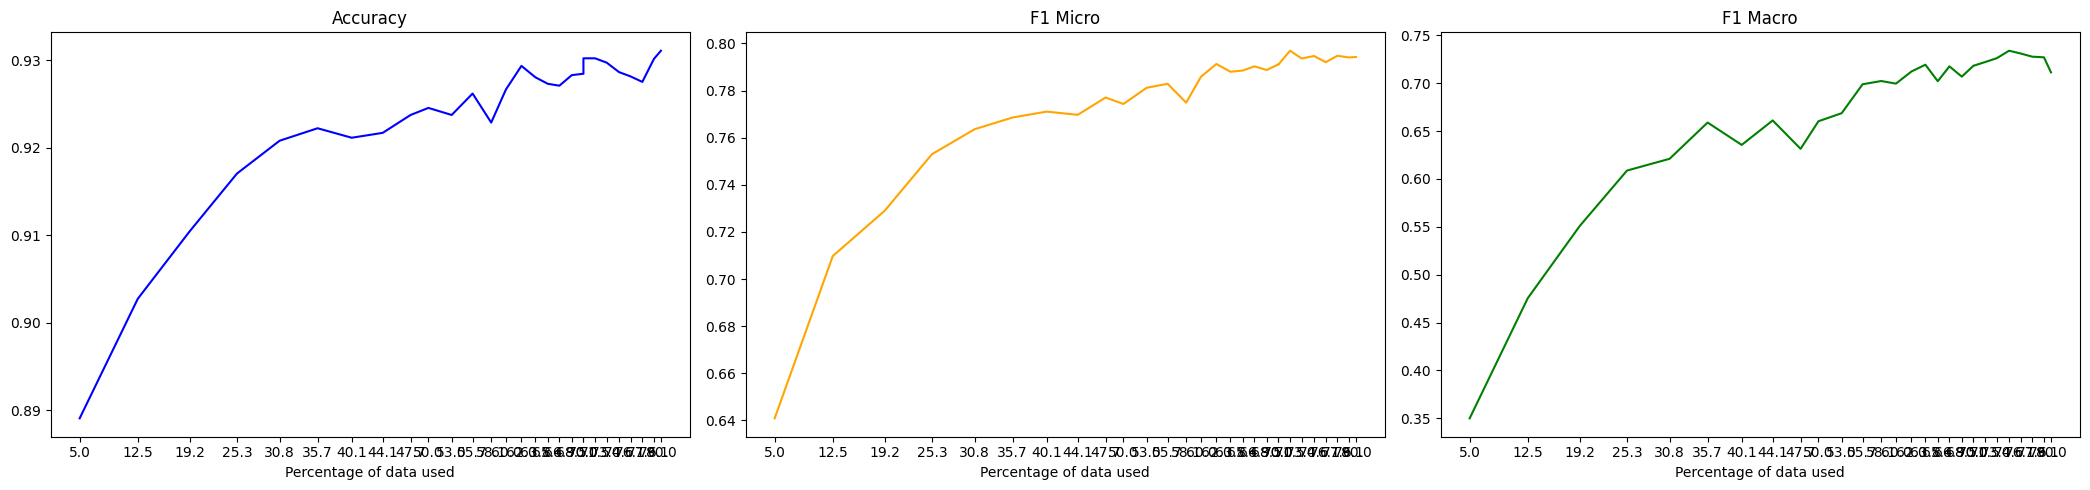

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5448, Accuracy: 0.8293, F1 Micro: 0.063, F1 Macro: 0.0218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4149, Accuracy: 0.8417, F1 Micro: 0.2125, F1 Macro: 0.0699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.389, Accuracy: 0.8438, F1 Micro: 0.2285, F1 Macro: 0.0804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3539, Accuracy: 0.8604, F1 Micro: 0.4052, F1 Macro: 0.1597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3143, Accuracy: 0.8723, F1 Micro: 0.5143, F1 Macro: 0.2487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2817, Accuracy: 0.8774, F1 Micro: 0.5561, F1 Macro: 0.2819
Epoch 7/10, Train Loss: 0.2562, Accuracy: 0.8755, F1 Micro: 0.5114, F1 Macro: 0.2739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2286, Accuracy: 0.884, F1 Micro: 0.5828, F1 Macro: 0.3379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.204, Accuracy: 0.8891, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4484, Accuracy: 0.8309, F1 Micro: 0.061, F1 Macro: 0.0243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.356, Accuracy: 0.8482, F1 Micro: 0.2509, F1 Macro: 0.0908
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3144, Accuracy: 0.8797, F1 Micro: 0.6231, F1 Macro: 0.3195
Epoch 4/10, Train Loss: 0.2638, Accuracy: 0.8823, F1 Micro: 0.5478, F1 Macro: 0.2774
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2281, Accuracy: 0.8927, F1 Micro: 0.671, F1 Macro: 0.3856
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1947, Accuracy: 0.8956, F1 Micro: 0.6716, F1 Macro: 0.442
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1614, Accuracy: 0.8996, F1 Micro: 0.6882, F1 Macro: 0.4621
Epoch 8/10, Train Loss: 0.1331, Accuracy: 0.9003, F1 Micro: 0.6878, F1 Macro: 0.4882
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1137, Accuracy: 0.9005, F1 Micro: 0.6984, F1 Macro: 0.5111
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4243, Accuracy: 0.8303, F1 Micro: 0.0423, F1 Macro: 0.0178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3391, Accuracy: 0.8813, F1 Micro: 0.6209, F1 Macro: 0.2966
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2701, Accuracy: 0.8967, F1 Micro: 0.6587, F1 Macro: 0.3657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2288, Accuracy: 0.9, F1 Micro: 0.6633, F1 Macro: 0.4419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1832, Accuracy: 0.9051, F1 Micro: 0.7051, F1 Macro: 0.4747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1546, Accuracy: 0.9087, F1 Micro: 0.712, F1 Macro: 0.5233
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1224, Accuracy: 0.9014, F1 Micro: 0.7239, F1 Macro: 0.5477
Epoch 8/10, Train Loss: 0.1012, Accuracy: 0.9096, F1 Micro: 0.7072, F1 Macro: 0.5192
Epoch 9/10, Train Loss: 0.0844, Accuracy: 0.9101, F1 Micro: 0.7222, F1 Macro: 0.5552
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4124, Accuracy: 0.8597, F1 Micro: 0.3945, F1 Macro: 0.1348
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3089, Accuracy: 0.8917, F1 Micro: 0.6321, F1 Macro: 0.3173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2464, Accuracy: 0.8994, F1 Micro: 0.6501, F1 Macro: 0.3974
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2055, Accuracy: 0.9099, F1 Micro: 0.7194, F1 Macro: 0.5374
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9078, F1 Micro: 0.7367, F1 Macro: 0.5501
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9135, F1 Micro: 0.7554, F1 Macro: 0.5785
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9167, F1 Micro: 0.7438, F1 Macro: 0.5724
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9134, F1 Micro: 0.7544, F1 Macro: 0.5901
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9173, F1 Micro: 0.7553, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4029, Accuracy: 0.8716, F1 Micro: 0.4937, F1 Macro: 0.217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2964, Accuracy: 0.8959, F1 Micro: 0.629, F1 Macro: 0.3346
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2388, Accuracy: 0.9103, F1 Micro: 0.7181, F1 Macro: 0.5077
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.9151, F1 Micro: 0.7297, F1 Macro: 0.553
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9138, F1 Micro: 0.7166, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9208, F1 Micro: 0.7599, F1 Macro: 0.6044
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.919, F1 Micro: 0.7521, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9196, F1 Micro: 0.7621, F1 Macro: 0.623
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9155, F1 Micro: 0.7565, F1 Macro: 0.6311
Epoch 10/10, Train Loss: 0.0606, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3937, Accuracy: 0.8804, F1 Micro: 0.5885, F1 Macro: 0.2833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.281, Accuracy: 0.9036, F1 Micro: 0.7107, F1 Macro: 0.4902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9132, F1 Micro: 0.7306, F1 Macro: 0.5576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1871, Accuracy: 0.9178, F1 Micro: 0.7458, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9173, F1 Micro: 0.7625, F1 Macro: 0.6131
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9167, F1 Micro: 0.7623, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9212, F1 Micro: 0.7699, F1 Macro: 0.6437
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9204, F1 Micro: 0.7632, F1 Macro: 0.6293
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9195, F1 Micro: 0.7684, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3781, Accuracy: 0.8832, F1 Micro: 0.6003, F1 Macro: 0.2784
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2779, Accuracy: 0.9043, F1 Micro: 0.7055, F1 Macro: 0.4335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.9161, F1 Micro: 0.7458, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9211, F1 Micro: 0.7652, F1 Macro: 0.5929
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9151, F1 Micro: 0.718, F1 Macro: 0.5662
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9193, F1 Micro: 0.7588, F1 Macro: 0.6195
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9162, F1 Micro: 0.762, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.92, F1 Micro: 0.767, F1 Macro: 0.637
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.9205, F1 Micro: 0.759, F1 Macro: 0.6504
Epoch 10/10, Train Loss: 0.0534, Accuracy: 0.921, F1 Micro: 0.7643, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8836, F1 Micro: 0.5727, F1 Macro: 0.2922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.9088, F1 Micro: 0.7233, F1 Macro: 0.5269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.9156, F1 Micro: 0.747, F1 Macro: 0.5721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9196, F1 Micro: 0.7607, F1 Macro: 0.6157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9223, F1 Micro: 0.7634, F1 Macro: 0.6197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9249, F1 Micro: 0.7775, F1 Macro: 0.6378
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9247, F1 Micro: 0.7712, F1 Macro: 0.6444
Epoch 8/10, Train Loss: 0.074, Accuracy: 0.9236, F1 Micro: 0.7689, F1 Macro: 0.66
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9227, F1 Micro: 0.7714, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3692, Accuracy: 0.8888, F1 Micro: 0.6309, F1 Macro: 0.3461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2621, Accuracy: 0.9106, F1 Micro: 0.7095, F1 Macro: 0.5313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9172, F1 Micro: 0.7437, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9208, F1 Micro: 0.7709, F1 Macro: 0.6193
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9231, F1 Micro: 0.7654, F1 Macro: 0.6278
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9218, F1 Micro: 0.7746, F1 Macro: 0.6581
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9216, F1 Micro: 0.7729, F1 Macro: 0.6415
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9241, F1 Micro: 0.7709, F1 Macro: 0.6639
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9215, F1 Micro: 0.7738, F1 Macro: 0.669
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.9218, F1 Micro: 0.774, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.8865, F1 Micro: 0.5866, F1 Macro: 0.2954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.9121, F1 Micro: 0.7376, F1 Macro: 0.5634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2083, Accuracy: 0.9113, F1 Micro: 0.7438, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9201, F1 Micro: 0.7662, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9234, F1 Micro: 0.7722, F1 Macro: 0.6449
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.923, F1 Micro: 0.7724, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.9229, F1 Micro: 0.773, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9229, F1 Micro: 0.7778, F1 Macro: 0.6796
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9215, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3657, Accuracy: 0.8872, F1 Micro: 0.5856, F1 Macro: 0.3129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.911, F1 Micro: 0.6989, F1 Macro: 0.5025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9214, F1 Micro: 0.7621, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9235, F1 Micro: 0.7747, F1 Macro: 0.6223
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9257, F1 Micro: 0.777, F1 Macro: 0.6534
Epoch 6/10, Train Loss: 0.1098, Accuracy: 0.9233, F1 Micro: 0.7745, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9235, F1 Micro: 0.7774, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9226, F1 Micro: 0.7778, F1 Macro: 0.6799
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9204, F1 Micro: 0.7747, F1 Macro: 0.6824
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3622, Accuracy: 0.8969, F1 Micro: 0.6604, F1 Macro: 0.4253
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.9153, F1 Micro: 0.7441, F1 Macro: 0.5576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9224, F1 Micro: 0.7736, F1 Macro: 0.6128
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9169, F1 Micro: 0.7697, F1 Macro: 0.6303
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.9261, F1 Micro: 0.7767, F1 Macro: 0.6443
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9247, F1 Micro: 0.7796, F1 Macro: 0.6441
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.924, F1 Micro: 0.7817, F1 Macro: 0.6665
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.9234, F1 Micro: 0.7781, F1 Macro: 0.678
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9249, F1 Micro: 0.7754, F1 Macro: 0.6868
Epoch 10/10, Train Loss: 0.0526, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3539, Accuracy: 0.8987, F1 Micro: 0.6768, F1 Macro: 0.4335
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.9116, F1 Micro: 0.7239, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9224, F1 Micro: 0.7618, F1 Macro: 0.6078
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9224, F1 Micro: 0.7512, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9271, F1 Micro: 0.786, F1 Macro: 0.6534
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9251, F1 Micro: 0.7829, F1 Macro: 0.6627
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9206, F1 Micro: 0.7768, F1 Macro: 0.6628
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9246, F1 Micro: 0.7805, F1 Macro: 0.6686
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9255, F1 Micro: 0.7812, F1 Macro: 0.6774
Epoch 10/10, Train Loss: 0.0493, Accuracy: 0.9257, F1 Micro: 0.7823, F1 Macro: 0.6956

 Iteration 7656: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3561, Accuracy: 0.8965, F1 Micro: 0.6445, F1 Macro: 0.3752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.9156, F1 Micro: 0.7391, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9205, F1 Micro: 0.7694, F1 Macro: 0.6057
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9227, F1 Micro: 0.7786, F1 Macro: 0.6325
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9215, F1 Micro: 0.7767, F1 Macro: 0.6517
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.924, F1 Micro: 0.7745, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9234, F1 Micro: 0.7811, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9249, F1 Micro: 0.7836, F1 Macro: 0.6884
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9248, F1 Micro: 0.7832, F1 Macro: 0.6981
Epoch 10/10, Train Loss: 0.0496, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.8998, F1 Micro: 0.6667, F1 Macro: 0.3755
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9164, F1 Micro: 0.7524, F1 Macro: 0.5631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9224, F1 Micro: 0.7644, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9258, F1 Micro: 0.7759, F1 Macro: 0.6385
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9246, F1 Micro: 0.7765, F1 Macro: 0.642
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.925, F1 Micro: 0.762, F1 Macro: 0.6342
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9234, F1 Micro: 0.7732, F1 Macro: 0.674
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.924, F1 Micro: 0.7806, F1 Macro: 0.6781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9256, F1 Micro: 0.7828, F1 Macro: 0.6995
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3464, Accuracy: 0.9001, F1 Micro: 0.6635, F1 Macro: 0.4285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.9175, F1 Micro: 0.7352, F1 Macro: 0.569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9221, F1 Micro: 0.7714, F1 Macro: 0.6185
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9268, F1 Micro: 0.779, F1 Macro: 0.6421
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9226, F1 Micro: 0.7757, F1 Macro: 0.6726
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9239, F1 Micro: 0.7787, F1 Macro: 0.665
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9242, F1 Micro: 0.7787, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9258, F1 Micro: 0.7842, F1 Macro: 0.6829
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.924, F1 Micro: 0.782, F1 Macro: 0.698
Epoch 10/10, Train Loss: 0.0458, Accuracy: 0.9241, F1 Micro: 0.7817, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3478, Accuracy: 0.9037, F1 Micro: 0.6989, F1 Macro: 0.4895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2342, Accuracy: 0.9163, F1 Micro: 0.7407, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.9193, F1 Micro: 0.7574, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9229, F1 Micro: 0.7777, F1 Macro: 0.6362
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9226, F1 Micro: 0.777, F1 Macro: 0.6425
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9216, F1 Micro: 0.7746, F1 Macro: 0.6849
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9267, F1 Micro: 0.786, F1 Macro: 0.6862
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9262, F1 Micro: 0.7795, F1 Macro: 0.6747
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9265, F1 Micro: 0.7828, F1 Macro: 0.6959
Epoch 10/10, Train Loss: 0.0473, Accuracy: 0.9245, F1 Micro: 0.7786, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3422, Accuracy: 0.9001, F1 Micro: 0.6603, F1 Macro: 0.3666
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.917, F1 Micro: 0.7364, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9215, F1 Micro: 0.7626, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9244, F1 Micro: 0.7706, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9268, F1 Micro: 0.7815, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9269, F1 Micro: 0.7898, F1 Macro: 0.6771
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9264, F1 Micro: 0.7781, F1 Macro: 0.6865
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9262, F1 Micro: 0.7858, F1 Macro: 0.7077
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9256, F1 Micro: 0.7847, F1 Macro: 0.7041
Epoch 10/10, Train Loss: 0.0469, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3386, Accuracy: 0.9029, F1 Micro: 0.7119, F1 Macro: 0.4738
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2371, Accuracy: 0.9179, F1 Micro: 0.7479, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1895, Accuracy: 0.9227, F1 Micro: 0.7504, F1 Macro: 0.607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9254, F1 Micro: 0.7788, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9237, F1 Micro: 0.7813, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9241, F1 Micro: 0.7821, F1 Macro: 0.6958
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9266, F1 Micro: 0.7867, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.929, F1 Micro: 0.7906, F1 Macro: 0.7073
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9259, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3405, Accuracy: 0.9065, F1 Micro: 0.7133, F1 Macro: 0.4844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2317, Accuracy: 0.9197, F1 Micro: 0.7529, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9242, F1 Micro: 0.7724, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9278, F1 Micro: 0.7813, F1 Macro: 0.6574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9255, F1 Micro: 0.7897, F1 Macro: 0.6744
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9258, F1 Micro: 0.7751, F1 Macro: 0.6842
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9253, F1 Micro: 0.7833, F1 Macro: 0.7028
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9249, F1 Micro: 0.7779, F1 Macro: 0.7105
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9266, F1 Micro: 0.781, F1 Macro: 0.7069
Epoch 10/10, Train Loss: 0.0475, Accuracy: 0.9252, F1 Micro: 0.7772, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3397, Accuracy: 0.8989, F1 Micro: 0.6547, F1 Macro: 0.3618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9193, F1 Micro: 0.7542, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1853, Accuracy: 0.9234, F1 Micro: 0.7759, F1 Macro: 0.6265
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9229, F1 Micro: 0.7655, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9263, F1 Micro: 0.7865, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9272, F1 Micro: 0.7873, F1 Macro: 0.6776
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9261, F1 Micro: 0.7783, F1 Macro: 0.6967
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9268, F1 Micro: 0.7864, F1 Macro: 0.7085
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9252, F1 Micro: 0.777, F1 Macro: 0.7004
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9283, F1 Micro: 0.7841, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3363, Accuracy: 0.8965, F1 Micro: 0.7057, F1 Macro: 0.4736
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2304, Accuracy: 0.9199, F1 Micro: 0.752, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.924, F1 Micro: 0.779, F1 Macro: 0.6449
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9246, F1 Micro: 0.784, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9259, F1 Micro: 0.7904, F1 Macro: 0.6935
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.93, F1 Micro: 0.7933, F1 Macro: 0.7086
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.9267, F1 Micro: 0.7897, F1 Macro: 0.7032
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9256, F1 Micro: 0.7851, F1 Macro: 0.7125
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9273, F1 Micro: 0.7863, F1 Macro: 0.7226
Epoch 10/10, Train Loss: 0.0456, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3309, Accuracy: 0.9057, F1 Micro: 0.691, F1 Macro: 0.4745
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2283, Accuracy: 0.9127, F1 Micro: 0.741, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.9259, F1 Micro: 0.7815, F1 Macro: 0.6417
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9274, F1 Micro: 0.7863, F1 Macro: 0.6506
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9263, F1 Micro: 0.7869, F1 Macro: 0.6902
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9276, F1 Micro: 0.7853, F1 Macro: 0.6833
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9266, F1 Micro: 0.7882, F1 Macro: 0.7036
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9266, F1 Micro: 0.7902, F1 Macro: 0.7171
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9275, F1 Micro: 0.7865, F1 Macro: 0.7151
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3359, Accuracy: 0.9061, F1 Micro: 0.7043, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2273, Accuracy: 0.9208, F1 Micro: 0.7572, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9254, F1 Micro: 0.7775, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9277, F1 Micro: 0.7887, F1 Macro: 0.6589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9272, F1 Micro: 0.7892, F1 Macro: 0.6993
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9271, F1 Micro: 0.7882, F1 Macro: 0.6988
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9238, F1 Micro: 0.7859, F1 Macro: 0.7024
Epoch 8/10, Train Loss: 0.0633, Accuracy: 0.9272, F1 Micro: 0.7844, F1 Macro: 0.7028
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9275, F1 Micro: 0.7873, F1 Macro: 0.7218
Epoch 10/10, Train Loss: 0.0449, Accuracy: 0.9253, F1 Micro: 0.7816, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3319, Accuracy: 0.9042, F1 Micro: 0.6749, F1 Macro: 0.4571
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2234, Accuracy: 0.9203, F1 Micro: 0.7665, F1 Macro: 0.5916
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1803, Accuracy: 0.9239, F1 Micro: 0.7732, F1 Macro: 0.6298
Epoch 4/10, Train Loss: 0.1435, Accuracy: 0.9252, F1 Micro: 0.7675, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9264, F1 Micro: 0.7833, F1 Macro: 0.6882
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9275, F1 Micro: 0.7928, F1 Macro: 0.7146
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9282, F1 Micro: 0.7842, F1 Macro: 0.7068
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9276, F1 Micro: 0.7915, F1 Macro: 0.7237
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9289, F1 Micro: 0.7938, F1 Macro: 0.7314
Epoch 10/10, Train Loss: 0.0447, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3275, Accuracy: 0.9079, F1 Micro: 0.7257, F1 Macro: 0.5153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.221, Accuracy: 0.9154, F1 Micro: 0.7529, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9266, F1 Micro: 0.7713, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1405, Accuracy: 0.9286, F1 Micro: 0.7883, F1 Macro: 0.688
Epoch 5/10, Train Loss: 0.1145, Accuracy: 0.9268, F1 Micro: 0.7867, F1 Macro: 0.6837
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.924, F1 Micro: 0.7818, F1 Macro: 0.7023
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9251, F1 Micro: 0.7873, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.925, F1 Micro: 0.7885, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9285, F1 Micro: 0.7897, F1 Macro: 0.7145
Epoch 10/10, Train Loss: 0.044, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3254, Accuracy: 0.908, F1 Micro: 0.6995, F1 Macro: 0.4875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2181, Accuracy: 0.9207, F1 Micro: 0.7466, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.9262, F1 Micro: 0.7666, F1 Macro: 0.6197
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9266, F1 Micro: 0.7822, F1 Macro: 0.6643
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9267, F1 Micro: 0.7741, F1 Macro: 0.6834
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9289, F1 Micro: 0.7899, F1 Macro: 0.7116
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9269, F1 Micro: 0.7946, F1 Macro: 0.7133
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9248, F1 Micro: 0.7873, F1 Macro: 0.7134
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9258, F1 Micro: 0.7816, F1 Macro: 0.7157
Epoch 10/10, Train Loss: 0.0425, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.324, Accuracy: 0.9062, F1 Micro: 0.691, F1 Macro: 0.4876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2148, Accuracy: 0.9207, F1 Micro: 0.7611, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9258, F1 Micro: 0.7795, F1 Macro: 0.6485
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1316, Accuracy: 0.9249, F1 Micro: 0.7873, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1078, Accuracy: 0.9283, F1 Micro: 0.7904, F1 Macro: 0.69
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9268, F1 Micro: 0.7868, F1 Macro: 0.7029
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.928, F1 Micro: 0.782, F1 Macro: 0.7133
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.9259, F1 Micro: 0.7893, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9287, F1 Micro: 0.7924, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 10/1

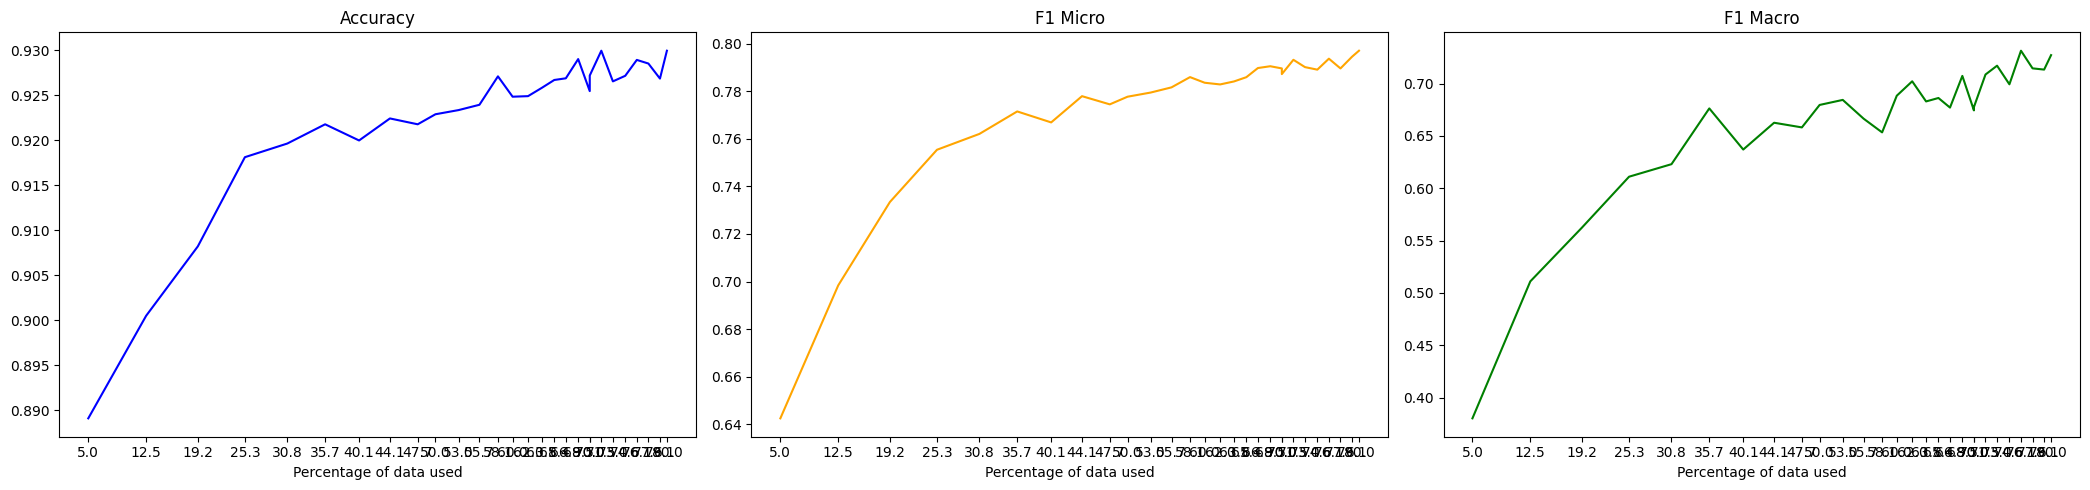

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8279, F1 Micro: 0.0267, F1 Macro: 0.0113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.8342, F1 Micro: 0.1125, F1 Macro: 0.0406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.372, Accuracy: 0.844, F1 Micro: 0.2472, F1 Macro: 0.0837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3504, Accuracy: 0.8621, F1 Micro: 0.468, F1 Macro: 0.1904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3382, Accuracy: 0.8729, F1 Micro: 0.5892, F1 Macro: 0.2711
Epoch 6/10, Train Loss: 0.2935, Accuracy: 0.8774, F1 Micro: 0.5687, F1 Macro: 0.2658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2645, Accuracy: 0.8822, F1 Micro: 0.6084, F1 Macro: 0.293
Epoch 8/10, Train Loss: 0.2436, Accuracy: 0.8842, F1 Micro: 0.6042, F1 Macro: 0.3032
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2213, Accuracy: 0.8868, F1 Micro: 0.6313, F1 Macro: 0.3455
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4643, Accuracy: 0.8289, F1 Micro: 0.0258, F1 Macro: 0.0112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3616, Accuracy: 0.8556, F1 Micro: 0.3388, F1 Macro: 0.1358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3169, Accuracy: 0.8788, F1 Micro: 0.5368, F1 Macro: 0.2505
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2758, Accuracy: 0.8868, F1 Micro: 0.5967, F1 Macro: 0.2923
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2218, Accuracy: 0.8964, F1 Micro: 0.6738, F1 Macro: 0.4112
Epoch 6/10, Train Loss: 0.1936, Accuracy: 0.8955, F1 Micro: 0.6302, F1 Macro: 0.4198
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1762, Accuracy: 0.9002, F1 Micro: 0.7057, F1 Macro: 0.5344
Epoch 8/10, Train Loss: 0.142, Accuracy: 0.9009, F1 Micro: 0.6764, F1 Macro: 0.4475
Epoch 9/10, Train Loss: 0.1252, Accuracy: 0.9005, F1 Micro: 0.6737, F1 Macro: 0.5033
Epoch 10/10, Train Loss: 0.1039, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.435, Accuracy: 0.8351, F1 Micro: 0.1166, F1 Macro: 0.0425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3382, Accuracy: 0.8731, F1 Micro: 0.6245, F1 Macro: 0.2939
Epoch 3/10, Train Loss: 0.2809, Accuracy: 0.8902, F1 Micro: 0.5992, F1 Macro: 0.3139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2265, Accuracy: 0.9027, F1 Micro: 0.686, F1 Macro: 0.4509
Epoch 5/10, Train Loss: 0.1907, Accuracy: 0.9034, F1 Micro: 0.682, F1 Macro: 0.4702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1519, Accuracy: 0.9072, F1 Micro: 0.7295, F1 Macro: 0.5477
Epoch 7/10, Train Loss: 0.1274, Accuracy: 0.9103, F1 Micro: 0.7252, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1119, Accuracy: 0.9107, F1 Micro: 0.7365, F1 Macro: 0.5598
Epoch 9/10, Train Loss: 0.0924, Accuracy: 0.912, F1 Micro: 0.718, F1 Macro: 0.5497
Epoch 10/10, Train Loss: 0.0807, Accuracy: 0.9116, F1 Micro: 0.7341, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4135, Accuracy: 0.8577, F1 Micro: 0.3803, F1 Macro: 0.1291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.316, Accuracy: 0.8883, F1 Micro: 0.5992, F1 Macro: 0.288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2457, Accuracy: 0.8935, F1 Micro: 0.6016, F1 Macro: 0.3509
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2069, Accuracy: 0.9094, F1 Micro: 0.723, F1 Macro: 0.533
Epoch 5/10, Train Loss: 0.1683, Accuracy: 0.9089, F1 Micro: 0.6979, F1 Macro: 0.5018
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9107, F1 Micro: 0.7119, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1124, Accuracy: 0.9142, F1 Micro: 0.7396, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9161, F1 Micro: 0.7461, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.9148, F1 Micro: 0.751, F1 Macro: 0.5896
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4062, Accuracy: 0.8767, F1 Micro: 0.5565, F1 Macro: 0.2507
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.296, Accuracy: 0.8974, F1 Micro: 0.674, F1 Macro: 0.4096
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.908, F1 Micro: 0.7266, F1 Macro: 0.5182
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1904, Accuracy: 0.9144, F1 Micro: 0.7421, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9194, F1 Micro: 0.7548, F1 Macro: 0.5823
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9123, F1 Micro: 0.7318, F1 Macro: 0.5665
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9209, F1 Micro: 0.7603, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9173, F1 Micro: 0.7612, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9188, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4024, Accuracy: 0.8799, F1 Micro: 0.5914, F1 Macro: 0.2737
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2907, Accuracy: 0.9011, F1 Micro: 0.6639, F1 Macro: 0.3867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.9094, F1 Micro: 0.7418, F1 Macro: 0.5511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.918, F1 Micro: 0.7582, F1 Macro: 0.5771
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9194, F1 Micro: 0.7451, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9193, F1 Micro: 0.7695, F1 Macro: 0.631
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9162, F1 Micro: 0.764, F1 Macro: 0.623
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9206, F1 Micro: 0.7701, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9222, F1 Micro: 0.7714, F1 Macro: 0.6516
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3915, Accuracy: 0.8739, F1 Micro: 0.4844, F1 Macro: 0.2179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2766, Accuracy: 0.9048, F1 Micro: 0.7127, F1 Macro: 0.4778
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.221, Accuracy: 0.9146, F1 Micro: 0.7419, F1 Macro: 0.5561
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9144, F1 Micro: 0.7236, F1 Macro: 0.565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9189, F1 Micro: 0.7512, F1 Macro: 0.5796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9204, F1 Micro: 0.7559, F1 Macro: 0.6147
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9232, F1 Micro: 0.7756, F1 Macro: 0.6345
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.9219, F1 Micro: 0.7628, F1 Macro: 0.6298
Epoch 9/10, Train Loss: 0.0682, Accuracy: 0.9218, F1 Micro: 0.7682, F1 Macro: 0.6551
Epoch 10/10, Train Loss: 0.0568, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3887, Accuracy: 0.8757, F1 Micro: 0.501, F1 Macro: 0.225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.9093, F1 Micro: 0.7122, F1 Macro: 0.5018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2245, Accuracy: 0.9156, F1 Micro: 0.7306, F1 Macro: 0.5178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9213, F1 Micro: 0.7628, F1 Macro: 0.5938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9207, F1 Micro: 0.766, F1 Macro: 0.6213
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1132, Accuracy: 0.9245, F1 Micro: 0.7738, F1 Macro: 0.6602
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9213, F1 Micro: 0.7697, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9218, F1 Micro: 0.7744, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.918, F1 Micro: 0.7711, F1 Macro: 0.6757
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3776, Accuracy: 0.8829, F1 Micro: 0.5599, F1 Macro: 0.2824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2624, Accuracy: 0.9098, F1 Micro: 0.703, F1 Macro: 0.5011
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9144, F1 Micro: 0.7561, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9195, F1 Micro: 0.7712, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9211, F1 Micro: 0.7749, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9219, F1 Micro: 0.7797, F1 Macro: 0.6901
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9244, F1 Micro: 0.7804, F1 Macro: 0.6828
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.92, F1 Micro: 0.7732, F1 Macro: 0.6816
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9223, F1 Micro: 0.7614, F1 Macro: 0.6734
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3712, Accuracy: 0.8903, F1 Micro: 0.6344, F1 Macro: 0.3049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.913, F1 Micro: 0.7282, F1 Macro: 0.5462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9178, F1 Micro: 0.7608, F1 Macro: 0.5909
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9216, F1 Micro: 0.7572, F1 Macro: 0.611
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.9234, F1 Micro: 0.7599, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9227, F1 Micro: 0.7793, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9242, F1 Micro: 0.7808, F1 Macro: 0.6608
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9219, F1 Micro: 0.7677, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9244, F1 Micro: 0.7819, F1 Macro: 0.6963
Epoch 10/10, Train Loss: 0.0512, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.8938, F1 Micro: 0.6377, F1 Macro: 0.347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2534, Accuracy: 0.9123, F1 Micro: 0.7413, F1 Macro: 0.569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9124, F1 Micro: 0.7624, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9239, F1 Micro: 0.7679, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9251, F1 Micro: 0.7727, F1 Macro: 0.6447
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9171, F1 Micro: 0.767, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.924, F1 Micro: 0.7836, F1 Macro: 0.7003
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9255, F1 Micro: 0.7819, F1 Macro: 0.7034
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9232, F1 Micro: 0.7684, F1 Macro: 0.695
Epoch 10/10, Train Loss: 0.0504, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3688, Accuracy: 0.8914, F1 Micro: 0.6119, F1 Macro: 0.3099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.9104, F1 Micro: 0.7231, F1 Macro: 0.5081
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.921, F1 Micro: 0.7679, F1 Macro: 0.5866
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.9234, F1 Micro: 0.7678, F1 Macro: 0.6307
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9265, F1 Micro: 0.7769, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9262, F1 Micro: 0.7793, F1 Macro: 0.6857
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9258, F1 Micro: 0.7836, F1 Macro: 0.6918
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9256, F1 Micro: 0.7741, F1 Macro: 0.6925
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9259, F1 Micro: 0.7826, F1 Macro: 0.7086
Epoch 10/10, Train Loss: 0.0473, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3634, Accuracy: 0.8953, F1 Micro: 0.6729, F1 Macro: 0.3748
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9121, F1 Micro: 0.7197, F1 Macro: 0.5492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.9208, F1 Micro: 0.76, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9232, F1 Micro: 0.7792, F1 Macro: 0.6313
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9245, F1 Micro: 0.7748, F1 Macro: 0.6671
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9252, F1 Micro: 0.7784, F1 Macro: 0.663
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.926, F1 Micro: 0.7815, F1 Macro: 0.6879
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9268, F1 Micro: 0.787, F1 Macro: 0.7165
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9286, F1 Micro: 0.7853, F1 Macro: 0.7118
Epoch 10/10, Train Loss: 0.0513, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3586, Accuracy: 0.8944, F1 Micro: 0.6216, F1 Macro: 0.3575
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.9167, F1 Micro: 0.7475, F1 Macro: 0.5423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9205, F1 Micro: 0.7511, F1 Macro: 0.5565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9254, F1 Micro: 0.7704, F1 Macro: 0.6157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9251, F1 Micro: 0.7755, F1 Macro: 0.636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9281, F1 Micro: 0.7858, F1 Macro: 0.691
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9241, F1 Micro: 0.778, F1 Macro: 0.696
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.929, F1 Micro: 0.7828, F1 Macro: 0.7035
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9251, F1 Micro: 0.7843, F1 Macro: 0.7145
Epoch 10/10, Train Loss: 0.0466, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3558, Accuracy: 0.8961, F1 Micro: 0.6475, F1 Macro: 0.3704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.9144, F1 Micro: 0.7278, F1 Macro: 0.5417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.9216, F1 Micro: 0.7619, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9267, F1 Micro: 0.7791, F1 Macro: 0.649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9266, F1 Micro: 0.7859, F1 Macro: 0.6885
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9268, F1 Micro: 0.7846, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9296, F1 Micro: 0.7871, F1 Macro: 0.697
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9267, F1 Micro: 0.7792, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9286, F1 Micro: 0.7873, F1 Macro: 0.7181
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3517, Accuracy: 0.8972, F1 Micro: 0.6456, F1 Macro: 0.3771
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.9158, F1 Micro: 0.7383, F1 Macro: 0.5379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.919, F1 Micro: 0.7721, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.925, F1 Micro: 0.7808, F1 Macro: 0.647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.928, F1 Micro: 0.7842, F1 Macro: 0.6713
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.924, F1 Micro: 0.7682, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.9261, F1 Micro: 0.7862, F1 Macro: 0.6986
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9271, F1 Micro: 0.7835, F1 Macro: 0.6973
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9275, F1 Micro: 0.7845, F1 Macro: 0.7117
Epoch 10/10, Train Loss: 0.0488, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.356, Accuracy: 0.8995, F1 Micro: 0.6997, F1 Macro: 0.4427
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.9157, F1 Micro: 0.7407, F1 Macro: 0.5697
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9177, F1 Micro: 0.7668, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9288, F1 Micro: 0.782, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9247, F1 Micro: 0.783, F1 Macro: 0.685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9244, F1 Micro: 0.7854, F1 Macro: 0.71
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.922, F1 Micro: 0.7779, F1 Macro: 0.6975
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9248, F1 Micro: 0.783, F1 Macro: 0.7094
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.927, F1 Micro: 0.7744, F1 Macro: 0.7032
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0.926

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3478, Accuracy: 0.8985, F1 Micro: 0.6597, F1 Macro: 0.3845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2356, Accuracy: 0.9179, F1 Micro: 0.7407, F1 Macro: 0.552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1858, Accuracy: 0.9241, F1 Micro: 0.7759, F1 Macro: 0.6194
Epoch 4/10, Train Loss: 0.1489, Accuracy: 0.9178, F1 Micro: 0.7731, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9268, F1 Micro: 0.7834, F1 Macro: 0.6781
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.927, F1 Micro: 0.7836, F1 Macro: 0.6976
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9267, F1 Micro: 0.7807, F1 Macro: 0.7073
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9255, F1 Micro: 0.7806, F1 Macro: 0.7152
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9229, F1 Micro: 0.778, F1 Macro: 0.711
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9238, F1 Micro: 0.7751, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3453, Accuracy: 0.9, F1 Micro: 0.6578, F1 Macro: 0.4025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.9147, F1 Micro: 0.74, F1 Macro: 0.5427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9213, F1 Micro: 0.7609, F1 Macro: 0.581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9246, F1 Micro: 0.7785, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9247, F1 Micro: 0.786, F1 Macro: 0.689
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9253, F1 Micro: 0.782, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9249, F1 Micro: 0.789, F1 Macro: 0.7161
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9275, F1 Micro: 0.7855, F1 Macro: 0.7123
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9272, F1 Micro: 0.7865, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3454, Accuracy: 0.897, F1 Micro: 0.7131, F1 Macro: 0.5056
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2369, Accuracy: 0.9192, F1 Micro: 0.7495, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.9249, F1 Micro: 0.7789, F1 Macro: 0.6253
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9261, F1 Micro: 0.7724, F1 Macro: 0.6307
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9259, F1 Micro: 0.7763, F1 Macro: 0.6862
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9273, F1 Micro: 0.7828, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9279, F1 Micro: 0.7889, F1 Macro: 0.709
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9249, F1 Micro: 0.7752, F1 Macro: 0.6984
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.923, F1 Micro: 0.776, F1 Macro: 0.7099
Epoch 10/10, Train Loss: 0.045, Accuracy: 0.9245, F1 Micro: 0.7756, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3491, Accuracy: 0.8986, F1 Micro: 0.6507, F1 Macro: 0.3993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2305, Accuracy: 0.919, F1 Micro: 0.7583, F1 Macro: 0.5784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9258, F1 Micro: 0.7845, F1 Macro: 0.6409
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9262, F1 Micro: 0.781, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9243, F1 Micro: 0.782, F1 Macro: 0.6671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9279, F1 Micro: 0.7874, F1 Macro: 0.7022
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.9252, F1 Micro: 0.7829, F1 Macro: 0.7001
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9224, F1 Micro: 0.7821, F1 Macro: 0.7172
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.926, F1 Micro: 0.7827, F1 Macro: 0.7201
Epoch 10/10, Train Loss: 0.0442, Accuracy: 0.9268, F1 Micro: 0.7807, F1 Macro: 0.7146

 Iteration 9218: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3459, Accuracy: 0.9042, F1 Micro: 0.7078, F1 Macro: 0.4537
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2381, Accuracy: 0.9183, F1 Micro: 0.7497, F1 Macro: 0.576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9261, F1 Micro: 0.7802, F1 Macro: 0.6316
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9254, F1 Micro: 0.7839, F1 Macro: 0.6799
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9254, F1 Micro: 0.7746, F1 Macro: 0.6894
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9276, F1 Micro: 0.7913, F1 Macro: 0.7156
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.931, F1 Micro: 0.793, F1 Macro: 0.7205
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9262, F1 Micro: 0.7849, F1 Macro: 0.7188
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9277, F1 Micro: 0.7919, F1 Macro: 0.7281
Epoch 10/10, Train Loss: 0.0431, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3462, Accuracy: 0.9011, F1 Micro: 0.6913, F1 Macro: 0.4099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.231, Accuracy: 0.9187, F1 Micro: 0.7405, F1 Macro: 0.5403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9255, F1 Micro: 0.7759, F1 Macro: 0.6385
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9292, F1 Micro: 0.7874, F1 Macro: 0.6924
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9257, F1 Micro: 0.7909, F1 Macro: 0.7038
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9268, F1 Micro: 0.7889, F1 Macro: 0.7137
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9249, F1 Micro: 0.7881, F1 Macro: 0.7166
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9209, F1 Micro: 0.7812, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9261, F1 Micro: 0.7776, F1 Macro: 0.719
Epoch 10/10, Train Loss: 0.0447, Accuracy: 0.9256, F1 Micro: 0.7882, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3384, Accuracy: 0.9058, F1 Micro: 0.7004, F1 Macro: 0.4623
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2242, Accuracy: 0.9167, F1 Micro: 0.7535, F1 Macro: 0.5762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9258, F1 Micro: 0.777, F1 Macro: 0.6451
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.9247, F1 Micro: 0.7837, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9288, F1 Micro: 0.789, F1 Macro: 0.6861
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9263, F1 Micro: 0.7859, F1 Macro: 0.6993
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9257, F1 Micro: 0.7845, F1 Macro: 0.7043
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9211, F1 Micro: 0.7832, F1 Macro: 0.721
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9252, F1 Micro: 0.7804, F1 Macro: 0.7103
Epoch 10/10, Train Loss: 0.0443, Accuracy: 0.9249, F1 Micro: 0.7835, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3398, Accuracy: 0.8982, F1 Micro: 0.6327, F1 Macro: 0.3857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2279, Accuracy: 0.9199, F1 Micro: 0.7424, F1 Macro: 0.5432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9247, F1 Micro: 0.7738, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9268, F1 Micro: 0.7841, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9261, F1 Micro: 0.7911, F1 Macro: 0.704
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9253, F1 Micro: 0.7853, F1 Macro: 0.7064
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9264, F1 Micro: 0.7806, F1 Macro: 0.706
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9271, F1 Micro: 0.7827, F1 Macro: 0.7112
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9262, F1 Micro: 0.7848, F1 Macro: 0.7222
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9257, F1 Micro: 0.7842, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3324, Accuracy: 0.9057, F1 Micro: 0.7038, F1 Macro: 0.464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2254, Accuracy: 0.921, F1 Micro: 0.755, F1 Macro: 0.5743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.928, F1 Micro: 0.7857, F1 Macro: 0.6592
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9266, F1 Micro: 0.7852, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.9293, F1 Micro: 0.7884, F1 Macro: 0.7012
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9272, F1 Micro: 0.7881, F1 Macro: 0.7158
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.9261, F1 Micro: 0.7866, F1 Macro: 0.7135
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9276, F1 Micro: 0.7866, F1 Macro: 0.7267
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9226, F1 Micro: 0.7804, F1 Macro: 0.7192
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9243, F1 Micro: 0.7879, F1 Macro: 0.716

 Iteration 10218: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.327, Accuracy: 0.9064, F1 Micro: 0.6976, F1 Macro: 0.4436
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2143, Accuracy: 0.9195, F1 Micro: 0.7447, F1 Macro: 0.581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.926, F1 Micro: 0.7857, F1 Macro: 0.6442
Epoch 4/10, Train Loss: 0.1386, Accuracy: 0.9249, F1 Micro: 0.7836, F1 Macro: 0.6778
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9259, F1 Micro: 0.7876, F1 Macro: 0.7031
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9268, F1 Micro: 0.7751, F1 Macro: 0.7015
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9249, F1 Micro: 0.7902, F1 Macro: 0.7208
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9263, F1 Micro: 0.7899, F1 Macro: 0.7196
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9235, F1 Micro: 0.7813, F1 Macro: 0.7176
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9237, F1 Micro: 0.7764, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3313, Accuracy: 0.9077, F1 Micro: 0.7006, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.217, Accuracy: 0.9218, F1 Micro: 0.7629, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9288, F1 Micro: 0.7861, F1 Macro: 0.6618
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.9268, F1 Micro: 0.7742, F1 Macro: 0.6361
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9289, F1 Micro: 0.7857, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9277, F1 Micro: 0.7896, F1 Macro: 0.711
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9262, F1 Micro: 0.7818, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9278, F1 Micro: 0.7913, F1 Macro: 0.7246
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9276, F1 Micro: 0.7879, F1 Macro: 0.723
Epoch 10/10, Train Loss: 0.0396, Accuracy: 0.9246, F1 Micro: 0.7817, F1 Mac

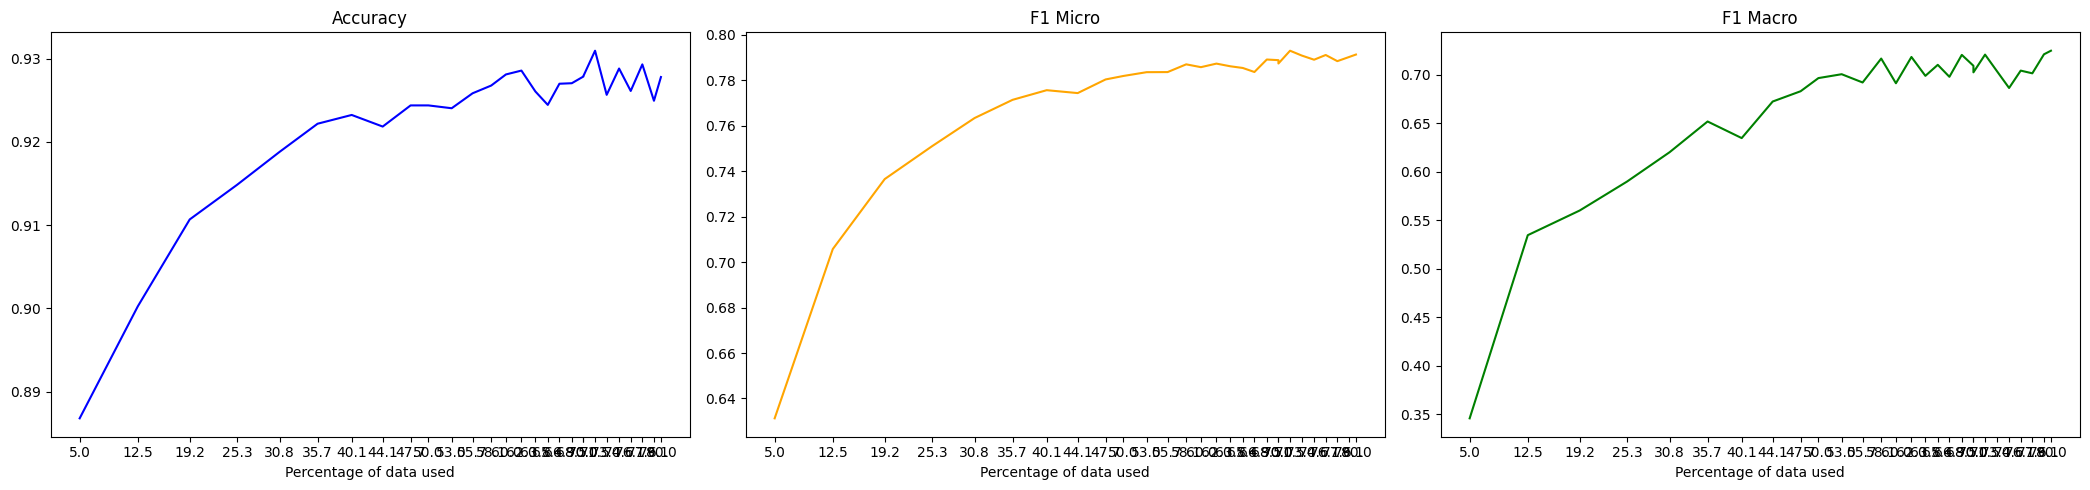

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.555, Accuracy: 0.8348, F1 Micro: 0.1412, F1 Macro: 0.0514
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.833, F1 Micro: 0.088, F1 Macro: 0.0343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.85, F1 Micro: 0.3323, F1 Macro: 0.1045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3599, Accuracy: 0.8618, F1 Micro: 0.4297, F1 Macro: 0.1746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3369, Accuracy: 0.8752, F1 Micro: 0.5274, F1 Macro: 0.2436
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2854, Accuracy: 0.8782, F1 Micro: 0.5421, F1 Macro: 0.254
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2723, Accuracy: 0.8832, F1 Micro: 0.5806, F1 Macro: 0.2996
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2324, Accuracy: 0.8863, F1 Micro: 0.611, F1 Macro: 0.3353
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2048, Accuracy: 0.8859, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4698, Accuracy: 0.8272, F1 Micro: 0.005, F1 Macro: 0.0023
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.362, Accuracy: 0.8631, F1 Micro: 0.4323, F1 Macro: 0.1543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.312, Accuracy: 0.8825, F1 Micro: 0.5762, F1 Macro: 0.2782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.276, Accuracy: 0.89, F1 Micro: 0.6405, F1 Macro: 0.3821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2263, Accuracy: 0.8947, F1 Micro: 0.6799, F1 Macro: 0.4115
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2014, Accuracy: 0.8924, F1 Micro: 0.6923, F1 Macro: 0.443
Epoch 7/10, Train Loss: 0.1704, Accuracy: 0.9014, F1 Micro: 0.684, F1 Macro: 0.4682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1429, Accuracy: 0.9037, F1 Micro: 0.6944, F1 Macro: 0.4899
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1203, Accuracy: 0.9057, F1 Micro: 0.70

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4417, Accuracy: 0.8413, F1 Micro: 0.1777, F1 Macro: 0.0665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3447, Accuracy: 0.8813, F1 Micro: 0.6127, F1 Macro: 0.2857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2801, Accuracy: 0.8947, F1 Micro: 0.675, F1 Macro: 0.4029
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2304, Accuracy: 0.9013, F1 Micro: 0.7052, F1 Macro: 0.4736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1992, Accuracy: 0.9059, F1 Micro: 0.706, F1 Macro: 0.4744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1618, Accuracy: 0.9051, F1 Micro: 0.7293, F1 Macro: 0.5358
Epoch 7/10, Train Loss: 0.1354, Accuracy: 0.9048, F1 Micro: 0.7181, F1 Macro: 0.5528
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1191, Accuracy: 0.9107, F1 Micro: 0.7322, F1 Macro: 0.562
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0912, Accuracy: 0.9096, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4251, Accuracy: 0.8557, F1 Micro: 0.3544, F1 Macro: 0.1129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3232, Accuracy: 0.8899, F1 Micro: 0.6357, F1 Macro: 0.3391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.261, Accuracy: 0.8998, F1 Micro: 0.6822, F1 Macro: 0.4652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2187, Accuracy: 0.9077, F1 Micro: 0.6939, F1 Macro: 0.5038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1809, Accuracy: 0.9094, F1 Micro: 0.7407, F1 Macro: 0.5601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1448, Accuracy: 0.9115, F1 Micro: 0.7411, F1 Macro: 0.5576
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.9129, F1 Micro: 0.7465, F1 Macro: 0.5715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.9134, F1 Micro: 0.7494, F1 Macro: 0.5974
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9159, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4077, Accuracy: 0.8764, F1 Micro: 0.5608, F1 Macro: 0.2432
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3006, Accuracy: 0.8986, F1 Micro: 0.6632, F1 Macro: 0.4362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.245, Accuracy: 0.9089, F1 Micro: 0.7161, F1 Macro: 0.4923
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1994, Accuracy: 0.9129, F1 Micro: 0.746, F1 Macro: 0.5651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9129, F1 Micro: 0.7469, F1 Macro: 0.552
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.9129, F1 Micro: 0.7406, F1 Macro: 0.5711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9105, F1 Micro: 0.7482, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9193, F1 Micro: 0.7553, F1 Macro: 0.6129
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9137, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3939, Accuracy: 0.8807, F1 Micro: 0.5949, F1 Macro: 0.2805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2808, Accuracy: 0.8942, F1 Micro: 0.6177, F1 Macro: 0.3606
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.9117, F1 Micro: 0.7181, F1 Macro: 0.4924
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.19, Accuracy: 0.9148, F1 Micro: 0.7261, F1 Macro: 0.5332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1544, Accuracy: 0.9185, F1 Micro: 0.7587, F1 Macro: 0.5861
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9145, F1 Micro: 0.7569, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9165, F1 Micro: 0.7647, F1 Macro: 0.6132
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9207, F1 Micro: 0.7623, F1 Macro: 0.6186
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.918, F1 Micro: 0.7625, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8808, F1 Micro: 0.6182, F1 Macro: 0.2946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2781, Accuracy: 0.9058, F1 Micro: 0.7146, F1 Macro: 0.5065
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.9137, F1 Micro: 0.7319, F1 Macro: 0.5205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9165, F1 Micro: 0.7533, F1 Macro: 0.5894
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9164, F1 Micro: 0.7618, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9209, F1 Micro: 0.7677, F1 Macro: 0.6328
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9215, F1 Micro: 0.7682, F1 Macro: 0.6234
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9191, F1 Micro: 0.7642, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9222, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8884, F1 Micro: 0.6197, F1 Macro: 0.3171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.9084, F1 Micro: 0.7223, F1 Macro: 0.5184
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.9145, F1 Micro: 0.7362, F1 Macro: 0.5089
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9178, F1 Micro: 0.7626, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9226, F1 Micro: 0.774, F1 Macro: 0.6251
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9241, F1 Micro: 0.7605, F1 Macro: 0.6105
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9237, F1 Micro: 0.7718, F1 Macro: 0.6394
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9238, F1 Micro: 0.7722, F1 Macro: 0.6606
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9205, F1 Micro: 0.7656, F1 Macro: 0.6632
Epoch 10/10, Train Loss: 0.0592, Accuracy: 0.9235, F1 Micro: 0.7698, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.373, Accuracy: 0.893, F1 Micro: 0.6488, F1 Macro: 0.3338
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.8975, F1 Micro: 0.6245, F1 Macro: 0.3807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.9159, F1 Micro: 0.7468, F1 Macro: 0.572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9208, F1 Micro: 0.765, F1 Macro: 0.615
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.922, F1 Micro: 0.764, F1 Macro: 0.609
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9204, F1 Micro: 0.7726, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0912, Accuracy: 0.9196, F1 Micro: 0.7738, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9223, F1 Micro: 0.7755, F1 Macro: 0.6697
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9229, F1 Micro: 0.7703, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8896, F1 Micro: 0.619, F1 Macro: 0.3178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2617, Accuracy: 0.9091, F1 Micro: 0.7027, F1 Macro: 0.4602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9177, F1 Micro: 0.7413, F1 Macro: 0.5549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9232, F1 Micro: 0.7712, F1 Macro: 0.6148
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9195, F1 Micro: 0.7694, F1 Macro: 0.6318
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9223, F1 Micro: 0.7629, F1 Macro: 0.6233
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9226, F1 Micro: 0.7736, F1 Macro: 0.6564
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9244, F1 Micro: 0.7804, F1 Macro: 0.6762
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9232, F1 Micro: 0.7766, F1 Macro: 0.6767
Epoch 10/10, Train Loss: 0.0544, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.891, F1 Micro: 0.6127, F1 Macro: 0.326
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9124, F1 Micro: 0.7187, F1 Macro: 0.5494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.913, F1 Micro: 0.7585, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9198, F1 Micro: 0.7671, F1 Macro: 0.6231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.924, F1 Micro: 0.7762, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9259, F1 Micro: 0.7803, F1 Macro: 0.6679
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9236, F1 Micro: 0.7752, F1 Macro: 0.6538
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.925, F1 Micro: 0.7733, F1 Macro: 0.6637
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9228, F1 Micro: 0.7686, F1 Macro: 0.6637
Epoch 10/10, Train Loss: 0.0552, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3668, Accuracy: 0.8965, F1 Micro: 0.6615, F1 Macro: 0.3775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.9128, F1 Micro: 0.7404, F1 Macro: 0.558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9209, F1 Micro: 0.7486, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9208, F1 Micro: 0.7665, F1 Macro: 0.6182
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9203, F1 Micro: 0.7728, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9266, F1 Micro: 0.7774, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9229, F1 Micro: 0.7814, F1 Macro: 0.6766
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9189, F1 Micro: 0.775, F1 Macro: 0.6808
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9219, F1 Micro: 0.7772, F1 Macro: 0.7073
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.365, Accuracy: 0.8979, F1 Micro: 0.6552, F1 Macro: 0.3855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2485, Accuracy: 0.9106, F1 Micro: 0.7415, F1 Macro: 0.5463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9198, F1 Micro: 0.7501, F1 Macro: 0.5623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9244, F1 Micro: 0.7734, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9218, F1 Micro: 0.779, F1 Macro: 0.6596
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9215, F1 Micro: 0.761, F1 Macro: 0.6674
Epoch 7/10, Train Loss: 0.0878, Accuracy: 0.9241, F1 Micro: 0.7641, F1 Macro: 0.6744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9242, F1 Micro: 0.7859, F1 Macro: 0.6986
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9244, F1 Micro: 0.7794, F1 Macro: 0.7023
Epoch 10/10, Train Loss: 0.0493, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3573, Accuracy: 0.8988, F1 Micro: 0.6682, F1 Macro: 0.3882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2481, Accuracy: 0.9147, F1 Micro: 0.7247, F1 Macro: 0.5355
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.924, F1 Micro: 0.7726, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9218, F1 Micro: 0.7758, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9234, F1 Micro: 0.7785, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.104, Accuracy: 0.9264, F1 Micro: 0.7822, F1 Macro: 0.6654
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9167, F1 Micro: 0.7694, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9245, F1 Micro: 0.7847, F1 Macro: 0.6911
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9265, F1 Micro: 0.7826, F1 Macro: 0.7087
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3545, Accuracy: 0.898, F1 Micro: 0.6717, F1 Macro: 0.3827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.9158, F1 Micro: 0.7529, F1 Macro: 0.5729
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.9232, F1 Micro: 0.752, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9269, F1 Micro: 0.7867, F1 Macro: 0.6456
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9259, F1 Micro: 0.7757, F1 Macro: 0.6718
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9285, F1 Micro: 0.786, F1 Macro: 0.6788
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9279, F1 Micro: 0.7868, F1 Macro: 0.7042
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9263, F1 Micro: 0.7832, F1 Macro: 0.678
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9268, F1 Micro: 0.7852, F1 Macro: 0.7023
Epoch 10/10, Train Loss: 0.0495, Accuracy: 0.9273, F1 Micro: 0.7835, F1 Macro: 0.7068

 Iteration 8165: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.8998, F1 Micro: 0.6866, F1 Macro: 0.4153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.9176, F1 Micro: 0.7429, F1 Macro: 0.5616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.9198, F1 Micro: 0.7431, F1 Macro: 0.5701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9261, F1 Micro: 0.7737, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9252, F1 Micro: 0.778, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9264, F1 Micro: 0.7869, F1 Macro: 0.6769
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9265, F1 Micro: 0.7766, F1 Macro: 0.6956
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9236, F1 Micro: 0.7807, F1 Macro: 0.6893
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9268, F1 Micro: 0.79, F1 Macro: 0.7091
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.351, Accuracy: 0.8966, F1 Micro: 0.6418, F1 Macro: 0.3565
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.9168, F1 Micro: 0.7522, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.9204, F1 Micro: 0.776, F1 Macro: 0.6202
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9145, F1 Micro: 0.7502, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9268, F1 Micro: 0.7893, F1 Macro: 0.6621
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9259, F1 Micro: 0.785, F1 Macro: 0.6894
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9255, F1 Micro: 0.786, F1 Macro: 0.6806
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9256, F1 Micro: 0.7896, F1 Macro: 0.7072
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9266, F1 Micro: 0.7835, F1 Macro: 0.7185
Epoch 10/10, Train Loss: 0.0485, Accuracy: 0.9257, F1 Micro: 0.7808, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3483, Accuracy: 0.8983, F1 Micro: 0.6646, F1 Macro: 0.49
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2399, Accuracy: 0.9182, F1 Micro: 0.745, F1 Macro: 0.57
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9241, F1 Micro: 0.7759, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9224, F1 Micro: 0.7785, F1 Macro: 0.6506
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9247, F1 Micro: 0.7822, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9252, F1 Micro: 0.7829, F1 Macro: 0.6897
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.9272, F1 Micro: 0.7925, F1 Macro: 0.7216
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.926, F1 Micro: 0.7881, F1 Macro: 0.7143
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9276, F1 Micro: 0.7809, F1 Macro: 0.7122
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3476, Accuracy: 0.9003, F1 Micro: 0.7156, F1 Macro: 0.5187
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2383, Accuracy: 0.9135, F1 Micro: 0.752, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9247, F1 Micro: 0.7685, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9253, F1 Micro: 0.774, F1 Macro: 0.6517
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9202, F1 Micro: 0.7725, F1 Macro: 0.6665
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9264, F1 Micro: 0.7829, F1 Macro: 0.6709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9271, F1 Micro: 0.7852, F1 Macro: 0.7068
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9245, F1 Micro: 0.7755, F1 Macro: 0.6998
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.925, F1 Micro: 0.7835, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.8992, F1 Micro: 0.6531, F1 Macro: 0.4161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2358, Accuracy: 0.9129, F1 Micro: 0.7481, F1 Macro: 0.5624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9241, F1 Micro: 0.7718, F1 Macro: 0.6158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9223, F1 Micro: 0.7778, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9222, F1 Micro: 0.7783, F1 Macro: 0.6706
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9271, F1 Micro: 0.7722, F1 Macro: 0.6699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9263, F1 Micro: 0.7824, F1 Macro: 0.6999
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9245, F1 Micro: 0.7797, F1 Macro: 0.7088
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9272, F1 Micro: 0.7887, F1 Macro: 0.7235
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3434, Accuracy: 0.9036, F1 Micro: 0.6847, F1 Macro: 0.4469
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.9075, F1 Micro: 0.7446, F1 Macro: 0.5627
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9233, F1 Micro: 0.7548, F1 Macro: 0.5938
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9262, F1 Micro: 0.7674, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9264, F1 Micro: 0.7856, F1 Macro: 0.6924
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9214, F1 Micro: 0.7797, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9268, F1 Micro: 0.7866, F1 Macro: 0.69
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9258, F1 Micro: 0.7788, F1 Macro: 0.6974
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9239, F1 Micro: 0.7836, F1 Macro: 0.7118
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3448, Accuracy: 0.9013, F1 Micro: 0.71, F1 Macro: 0.4463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2396, Accuracy: 0.9193, F1 Micro: 0.7544, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1892, Accuracy: 0.9226, F1 Micro: 0.7785, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9274, F1 Micro: 0.7853, F1 Macro: 0.6641
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9276, F1 Micro: 0.7783, F1 Macro: 0.6516
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9246, F1 Micro: 0.7837, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9271, F1 Micro: 0.787, F1 Macro: 0.7157
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9253, F1 Micro: 0.7885, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9281, F1 Micro: 0.7942, F1 Macro: 0.733
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3415, Accuracy: 0.904, F1 Micro: 0.686, F1 Macro: 0.4558
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2321, Accuracy: 0.919, F1 Micro: 0.7578, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.9211, F1 Micro: 0.773, F1 Macro: 0.6158
Epoch 4/10, Train Loss: 0.1454, Accuracy: 0.9264, F1 Micro: 0.7708, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9274, F1 Micro: 0.776, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9264, F1 Micro: 0.7851, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9277, F1 Micro: 0.7877, F1 Macro: 0.7206
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.925, F1 Micro: 0.7804, F1 Macro: 0.6992
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9279, F1 Micro: 0.7812, F1 Macro: 0.7111
Epoch 10/10, Train Loss: 0.0452, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3394, Accuracy: 0.907, F1 Micro: 0.7049, F1 Macro: 0.4862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.23, Accuracy: 0.919, F1 Micro: 0.7454, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.9177, F1 Micro: 0.7695, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1446, Accuracy: 0.9281, F1 Micro: 0.7803, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9284, F1 Micro: 0.7866, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9276, F1 Micro: 0.7889, F1 Macro: 0.7141
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9265, F1 Micro: 0.7861, F1 Macro: 0.7163
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9214, F1 Micro: 0.7765, F1 Macro: 0.7103
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9268, F1 Micro: 0.7894, F1 Macro: 0.7289
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3372, Accuracy: 0.9045, F1 Micro: 0.6976, F1 Macro: 0.4607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2265, Accuracy: 0.9173, F1 Micro: 0.7502, F1 Macro: 0.5825
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9252, F1 Micro: 0.775, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9273, F1 Micro: 0.7861, F1 Macro: 0.6766
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9272, F1 Micro: 0.779, F1 Macro: 0.6863
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9273, F1 Micro: 0.7845, F1 Macro: 0.7075
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9287, F1 Micro: 0.7816, F1 Macro: 0.7003
Epoch 8/10, Train Loss: 0.0633, Accuracy: 0.9284, F1 Micro: 0.782, F1 Macro: 0.7162
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9239, F1 Micro: 0.7827, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0461, Accuracy: 0.9276, F1 Micro: 0.7878, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3307, Accuracy: 0.9055, F1 Micro: 0.7002, F1 Macro: 0.447
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2247, Accuracy: 0.9212, F1 Micro: 0.7639, F1 Macro: 0.5913
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9212, F1 Micro: 0.7569, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.9258, F1 Micro: 0.7742, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.9257, F1 Micro: 0.7874, F1 Macro: 0.7061
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9267, F1 Micro: 0.7876, F1 Macro: 0.6911
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9269, F1 Micro: 0.7898, F1 Macro: 0.7211
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9266, F1 Micro: 0.788, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9285, F1 Micro: 0.7908, F1 Macro: 0.7273
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3313, Accuracy: 0.9059, F1 Micro: 0.7132, F1 Macro: 0.512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2219, Accuracy: 0.919, F1 Micro: 0.7555, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9246, F1 Micro: 0.7799, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9287, F1 Micro: 0.7865, F1 Macro: 0.6912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1123, Accuracy: 0.9288, F1 Micro: 0.7892, F1 Macro: 0.6945
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9276, F1 Micro: 0.789, F1 Macro: 0.7095
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9271, F1 Micro: 0.7756, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9278, F1 Micro: 0.7893, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9266, F1 Micro: 0.7899, F1 Macro: 0.7238
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3286, Accuracy: 0.9038, F1 Micro: 0.6976, F1 Macro: 0.4789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2163, Accuracy: 0.917, F1 Micro: 0.7427, F1 Macro: 0.5526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.9275, F1 Micro: 0.773, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1399, Accuracy: 0.9171, F1 Micro: 0.7742, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.9291, F1 Micro: 0.792, F1 Macro: 0.6993
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9274, F1 Micro: 0.7874, F1 Macro: 0.7107
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9288, F1 Micro: 0.7915, F1 Macro: 0.7207
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9268, F1 Micro: 0.781, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.9296, F1 Micro: 0.7953, F1 Macro: 0.7337
Epoch 10/10, Train Loss: 0.0408, Accuracy:

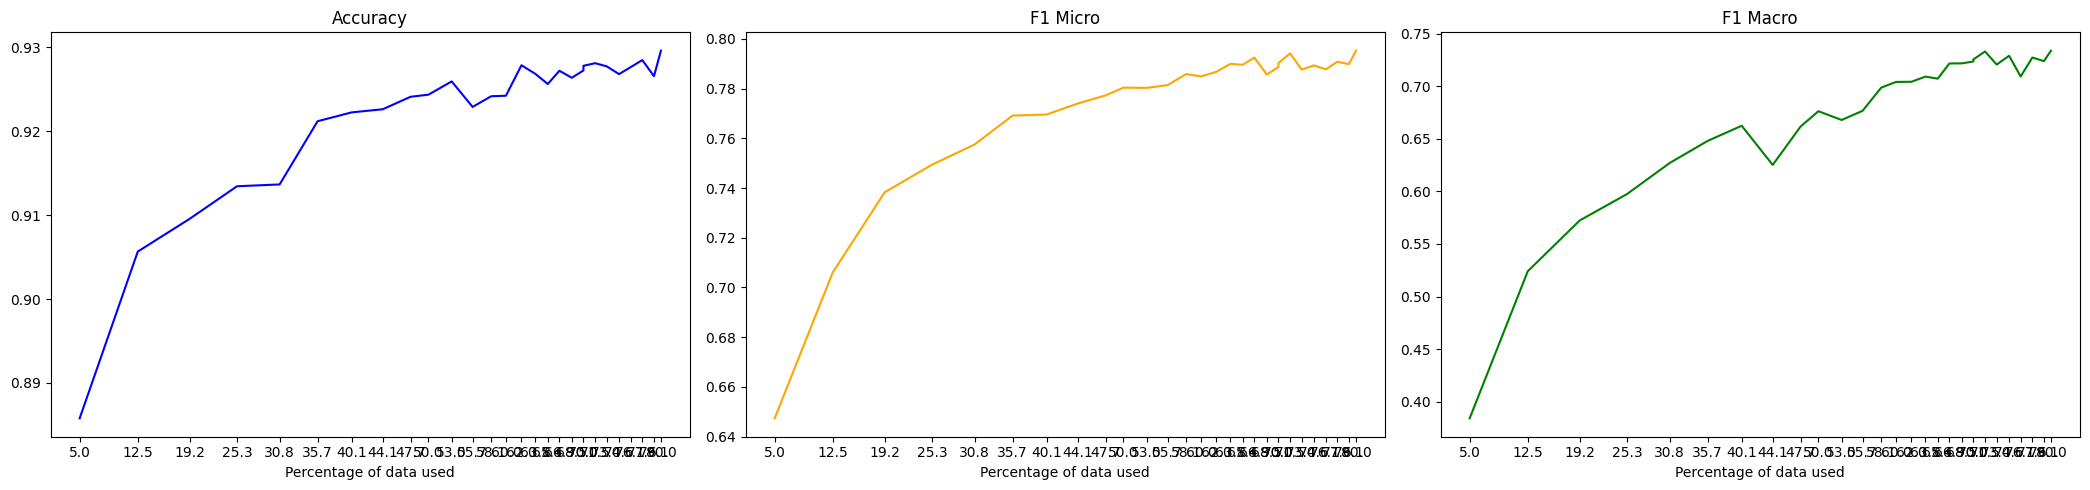

In [ ]:
active_learning(seeds[4], 4)